In [1]:
from Scripts.Configs.ConfigClass import Config
from Scripts.DataManager.GraphConstructor.GraphConstructor import TextGraphType
import os
from Scripts.DataManager.GraphLoader.AGGraphDataModule import AGGraphDataModule
from Scripts.DataManager.GraphLoader.YelpGraphDataModule import YelpGraphDataModule
import torch
from torch.utils.flop_counter import FlopCounterMode

config = Config(r'C:\Users\fardin\Projects\ColorIntelligence')
# config = Config(r'E:\Darsi\Payan Name Arshad\Second Work\ColorIntelligence2\ColorIntelligence')
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 256


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:90: UserWarning: An issue occurred while importing 'torch-spline-conv'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\torch_geometric\typing.py:101: UserWarning: An issue occurred while importing 'torch-sparse'. Disabling its usage. Stacktrace: [WinError 127] The specified procedure could not be found
  warnings.warn(f"An issue occurred while importing 'torch-sparse'. "


In [2]:
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding4 import HeteroDeepGraphEmbedding4
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding5 import HeteroDeepGraphEmbedding5
from Scripts.Models.GraphEmbedding.HeteroDeepGraphEmbedding6 import HeteroDeepGraphEmbedding6

In [3]:
from Scripts.Models.LightningModels.LightningModels import HeteroMultiClassLightningModel, HeteroBinaryLightningModel
from Scripts.Models.LossFunctions.HeteroLossFunctions import MulticlassHeteroLoss1, MulticlassHeteroLoss2, MulticlassHeteroLoss3, HeteroLoss2
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint
import lightning as L
from lightning.pytorch.tuner import Tuner
from Scripts.Models.ModelsManager.ClassifierModelManager import ClassifierModelManager

In [7]:
learning_chuncks = [range(int(5e4+1)), range(int(0.5e5), int(1e5+1)), range(int(1e5), int(1.5e5+1)), range(int(1.5e5), int(2e5+1)), range(int(2e5), int(2.5e5+1)), range(int(2.5e5), int(3e5+1)), range(int(3e5), int(3.5e5+1)), range(int(3.5e5), int(4e5+1)), range(int(4e5), int(4.5e5+1)), range(int(4.5e5), int(5e5+1)), range(int(5e5), int(5.6e5+1))]
# learning_chuncks = [range(int(1e3+1)), range(int(1e3), int(2e3+1)), range(int(2e3), int(3e3+1)),
#                     range(int(3e3), int(4e3+1)), range(int(4e3), int(5e3+1)), range(int(5e3), 6000)]
edge_type_weights = [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.]
graph_type = TextGraphType.SENTIMENT
metadata = (['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
 [('dep', 'dep_word', 'word'),
  ('word', 'word_dep', 'dep'),
  ('tag', 'tag_word', 'word'),
  ('word', 'word_tag', 'tag'),
  ('word', 'seq', 'word'),
  ('general', 'general_sentence', 'sentence'),
  ('sentence', 'sentence_general', 'general'),
  ('word', 'word_sentence', 'sentence'),
  ('sentence', 'sentence_word', 'word'),
  ('word', 'word_sentiment', 'sentiment'),
  ('sentiment', 'sentiment_word', 'word')])

In [8]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)
graph_embedding = graph_embedding.to(device)
callbacks = [
ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
]
loss_func = HeteroLoss2(exception_keys=['word'], enc_factor=0.0001)
optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.0015)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16, 24, 32, 40, 55], gamma=0.5, verbose=True)
lightning_model = HeteroBinaryLightningModel(graph_embedding,
                                    optimizer=optimizer,
                                    loss_func=loss_func,
                                    learning_rate=0.045,
                                    batch_size=batch_size,
                                    user_lr_scheduler=True,
                                    lr_scheduler=lr_scheduler,
                                    min_lr=0.0005
                                    ).to(device)
lightning_model.model.to(device)

max_epochs=0
model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_Yelp_1',device=device, num_train_epoch=max_epochs)


c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Adjusting learning rate of group 0 to 4.5000e-03.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:37<00:00, 21.16s/it]


self.shuffle: False
bbbb


Missing logger folder: logs/hetero_model_Yelp_1
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=5` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:11<00:00, 21.84s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=10` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:48<00:00, 22.56s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=15` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:16<00:00, 21.93s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=20` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:37<00:00, 21.15s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=25` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:00<00:00, 21.61s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=30` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [24:02<00:00, 28.84s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=35` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [20:25<00:00, 24.50s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=40` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:59<00:00, 21.58s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=45` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:36<00:00, 21.12s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=50` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [20:50<00:00, 20.85s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=55` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:34<00:00, 21.09s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=60` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:15<00:00, 20.71s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=65` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:12<00:00, 21.85s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:34<00:00, 21.08s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=75` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:26<00:00, 19.73s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=80` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:56<00:00, 20.34s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=85` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:04<00:00, 20.49s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=90` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [21:35<00:00, 25.91s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=95` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:43<00:00, 20.07s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=100` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [20:15<00:00, 24.31s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=105` reached.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\pandas\plotting\_matplotlib\core.py:509: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig = self.plt.figure(figsize=self.figsize)


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [19:43<00:00, 19.73s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=110` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:46<00:00, 20.14s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=115` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:28<00:00, 19.78s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=120` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:55<00:00, 21.51s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=125` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [22:18<00:00, 26.76s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=130` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:58<00:00, 20.37s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=135` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:28<00:00, 20.96s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=140` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:28<00:00, 20.96s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=145` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:30<00:00, 21.02s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=150` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:20<00:00, 20.82s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=155` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:15<00:00, 20.71s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=160` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [21:36<00:00, 21.62s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=165` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:29<00:00, 22.20s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=170` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:17<00:00, 20.74s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=175` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:45<00:00, 22.50s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=180` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:47<00:00, 22.56s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=185` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:02<00:00, 21.65s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=190` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:03<00:00, 21.67s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=195` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:52<00:00, 21.46s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=200` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:40<00:00, 22.41s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=205` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:52<00:00, 21.46s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=210` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:40<00:00, 22.41s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=215` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [22:46<00:00, 22.77s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=220` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:36<00:00, 22.32s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=225` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [25:17<00:00, 30.35s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=230` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [25:02<00:00, 30.06s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=235` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:38<00:00, 22.38s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=240` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [18:45<00:00, 22.51s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=245` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:10<00:00, 19.41s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=250` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:27<00:00, 20.94s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=255` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:29<00:00, 18.59s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=260` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:30<00:00, 21.01s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=265` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:11<00:00, 18.23s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=270` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [18:07<00:00, 18.12s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=275` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:54<00:00, 19.09s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=280` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:43<00:00, 17.68s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=285` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:16<00:00, 19.53s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=290` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:44<00:00, 18.90s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=295` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:23<00:00, 18.47s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:37<00:00, 19.95s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=305` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:34<00:00, 18.70s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=310` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:05<00:00, 18.12s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=315` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:15<00:00, 18.32s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=320` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:57<00:00, 19.14s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=325` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [17:53<00:00, 17.88s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=330` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [20:14<00:00, 24.29s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=335` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:41<00:00, 17.62s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=340` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [19:49<00:00, 23.79s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=345` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:08<00:00, 19.38s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=350` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [23:23<00:00, 28.07s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=355` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:03<00:00, 18.06s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=360` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:43<00:00, 20.07s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=365` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:54<00:00, 20.30s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=370` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:20<00:00, 20.81s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=375` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:48<00:00, 20.16s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=380` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [20:14<00:00, 20.24s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=385` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:25<00:00, 20.91s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=390` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:36<00:00, 19.93s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=395` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:23<00:00, 20.88s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=400` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:32<00:00, 19.84s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=405` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:32<00:00, 18.65s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=410` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:29<00:00, 19.79s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=415` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [28:22<00:00, 34.05s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=420` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [20:05<00:00, 24.10s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=425` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [19:05<00:00, 22.91s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=430` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [19:28<00:00, 23.38s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=435` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [20:38<00:00, 20.64s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=440` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:41<00:00, 20.03s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=445` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:06<00:00, 19.33s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=450` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:04<00:00, 20.48s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=455` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:30<00:00, 19.80s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=460` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:42<00:00, 18.85s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=465` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:39<00:00, 18.79s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=470` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:12<00:00, 18.25s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=475` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [17:41<00:00, 21.23s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=480` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:55<00:00, 19.11s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=485` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:12<00:00, 17.05s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=490` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [18:37<00:00, 18.62s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=495` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:48<00:00, 17.76s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=500` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:32<00:00, 19.86s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=505` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:00<00:00, 19.21s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=510` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:43<00:00, 17.68s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=515` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:01<00:00, 16.82s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=520` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:19<00:00, 17.20s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=525` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [15:00<00:00, 18.00s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=530` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [16:31<00:00, 19.83s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=535` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:35<00:00, 17.52s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=540` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 50/50 [14:28<00:00, 17.37s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=545` reached.


torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000])
torch.Size([2000])
filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 60/60 [16:57<00:00, 16.96s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=550` reached.


torch.Size([2400, 1])
torch.Size([2400, 1])
torch.Size([2400])
torch.Size([2400])


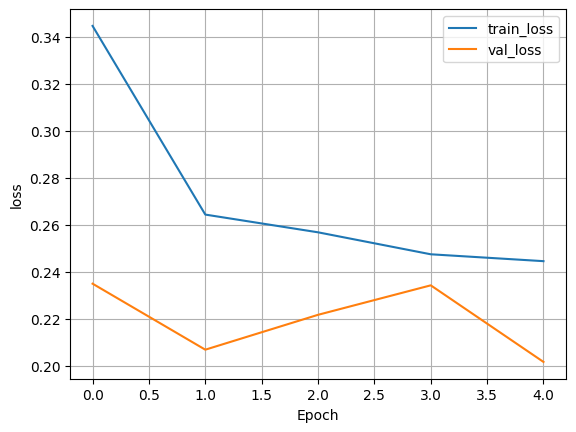

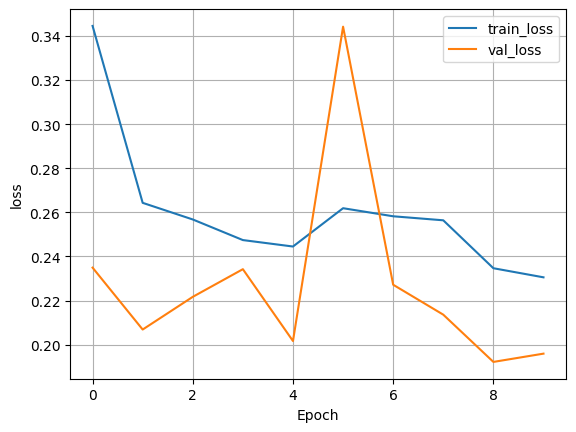

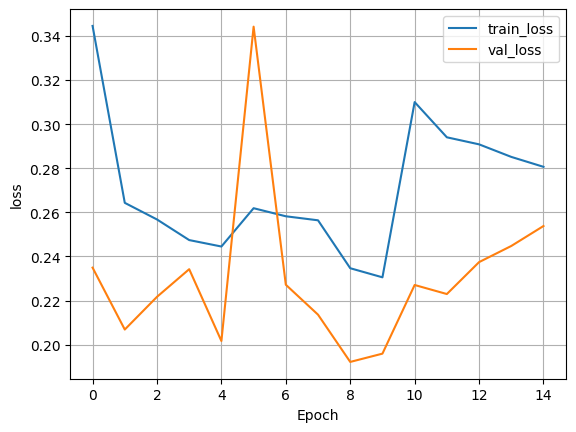

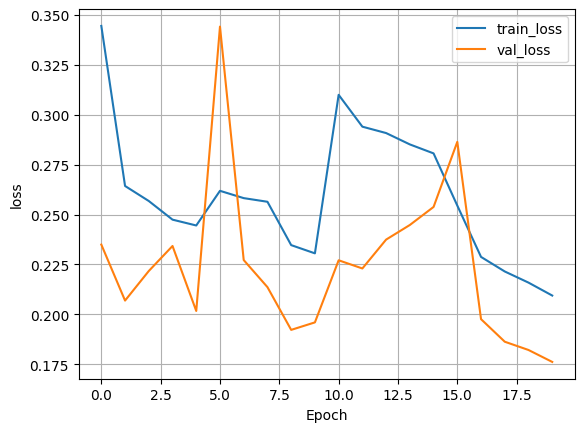

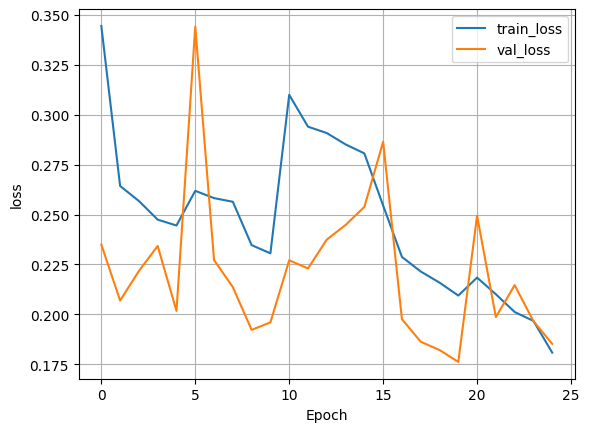

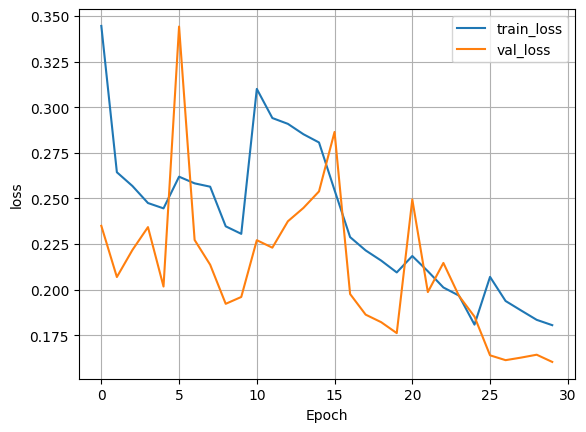

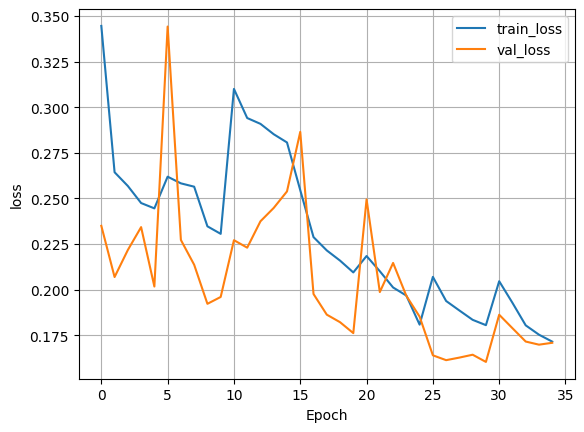

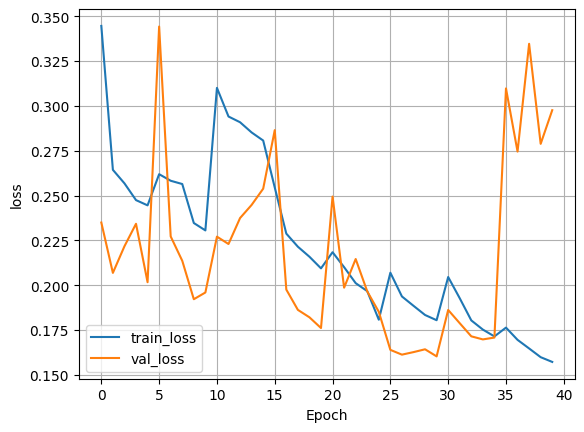

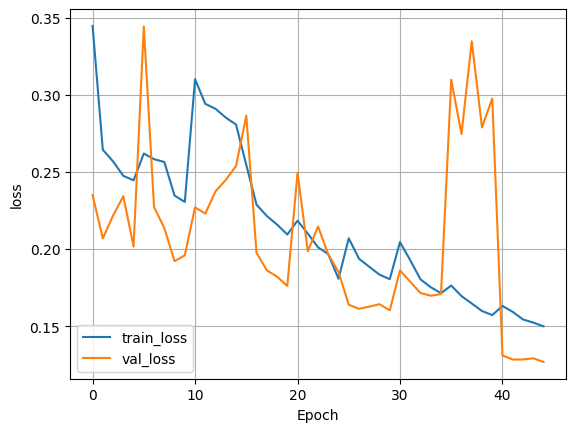

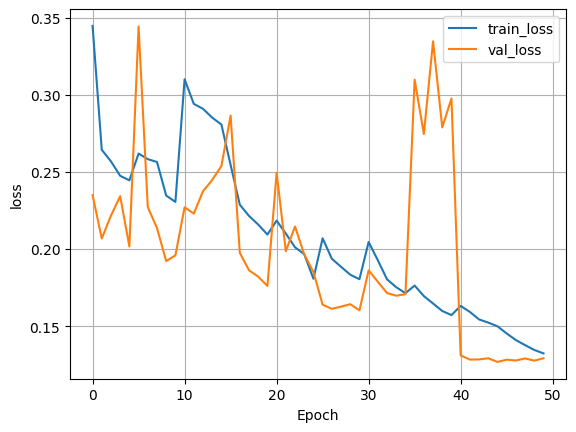

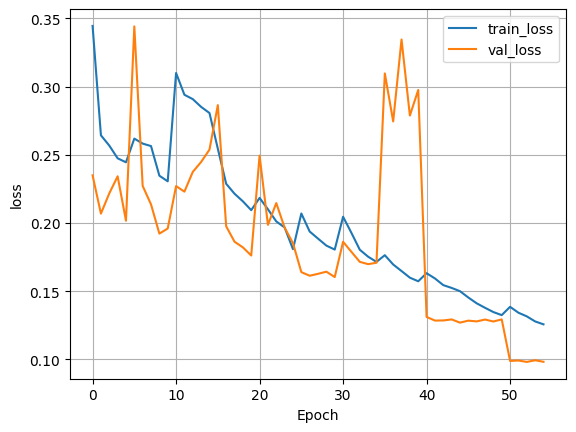

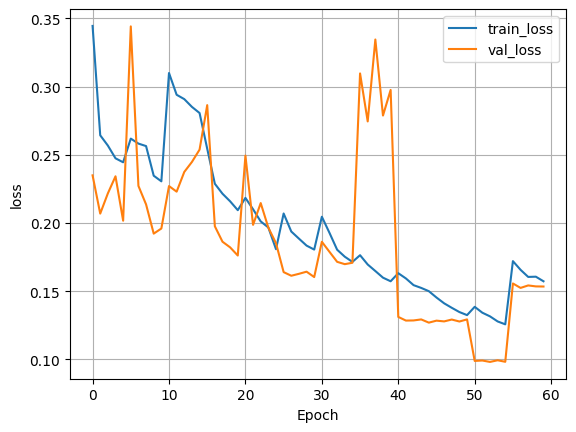

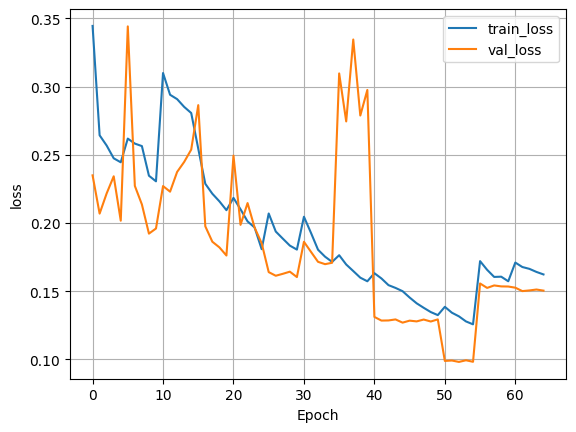

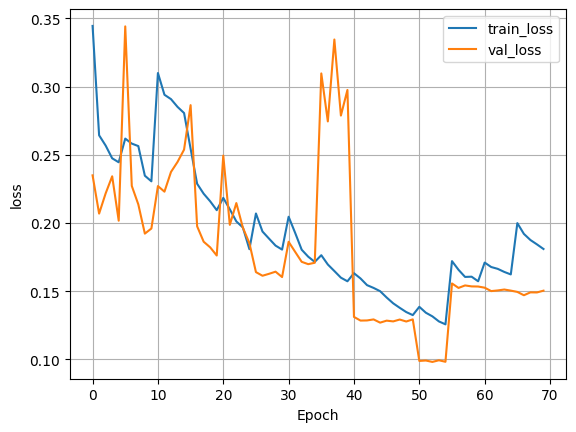

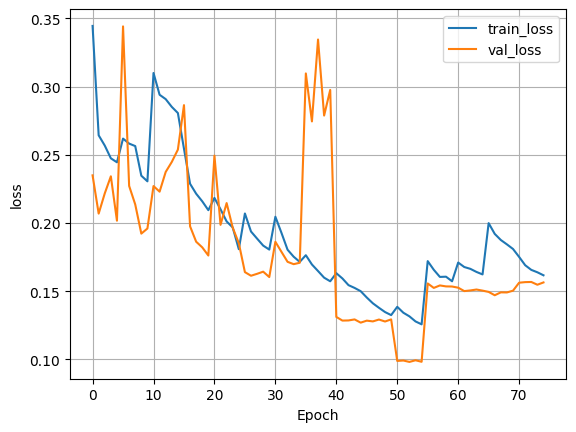

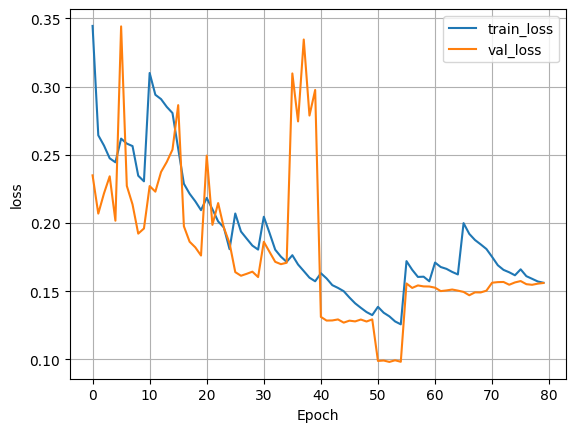

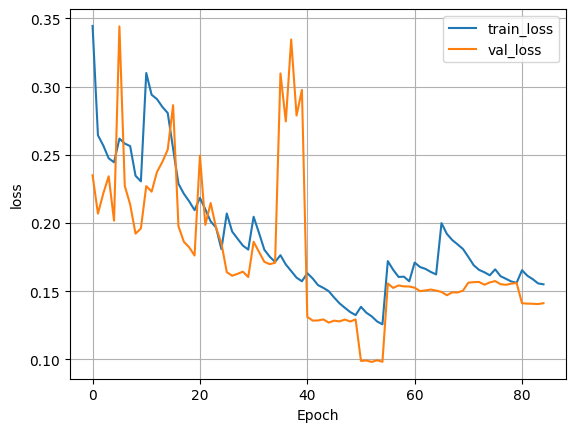

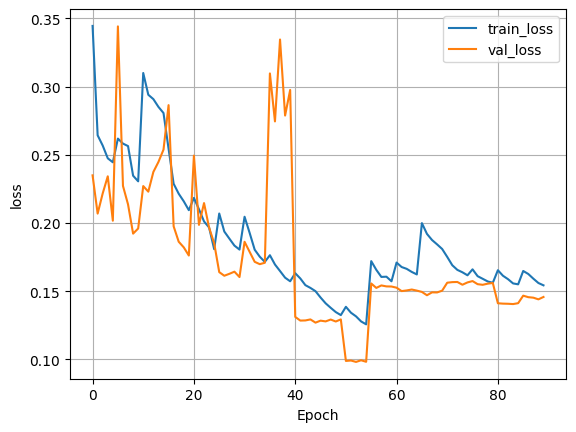

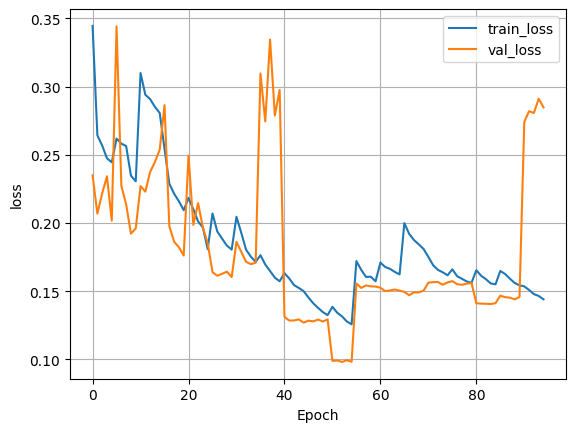

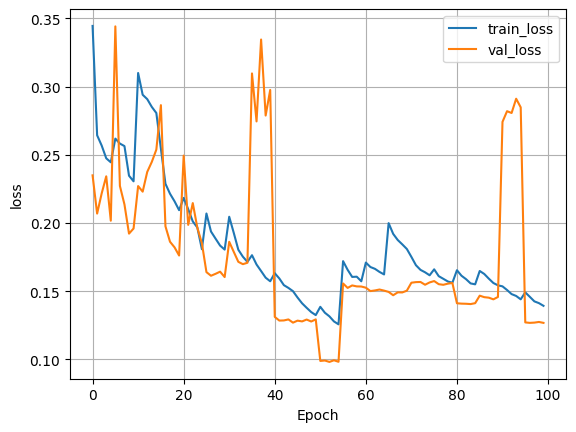

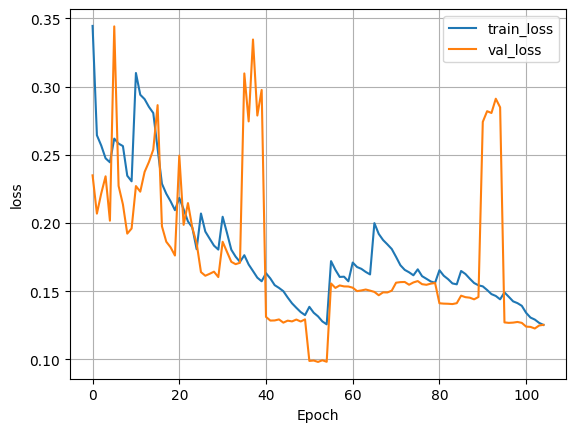

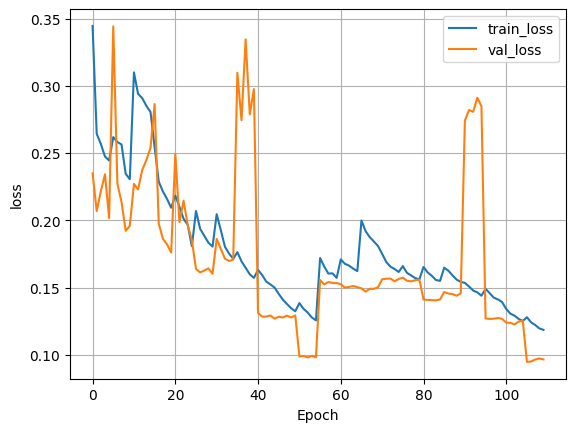

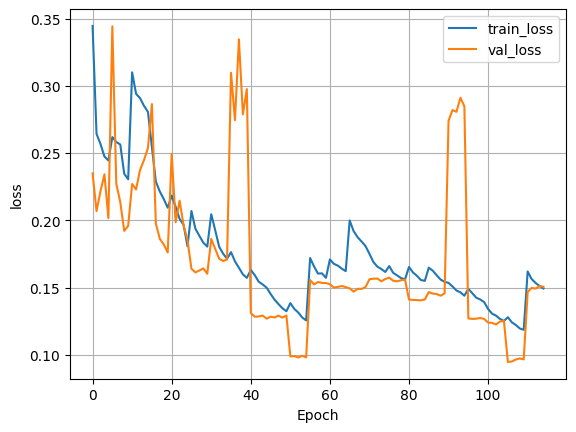

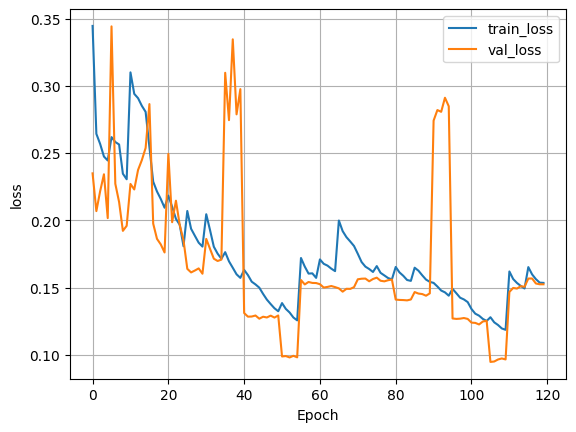

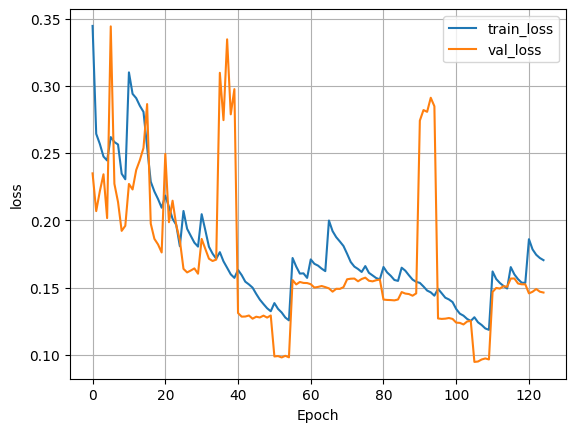

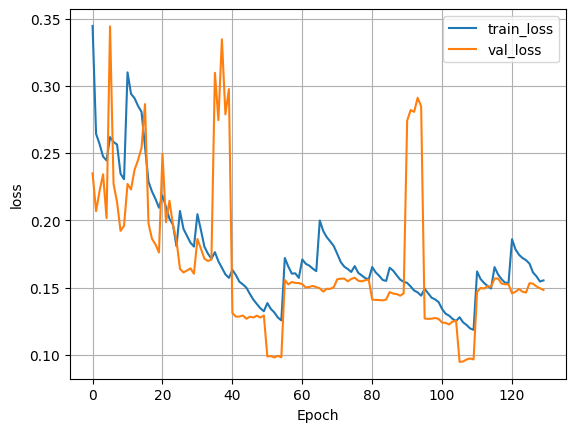

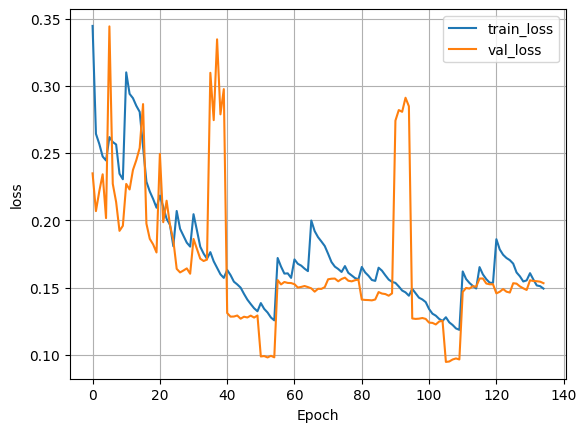

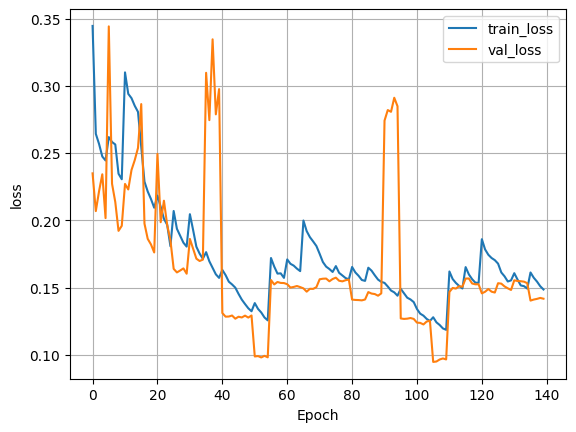

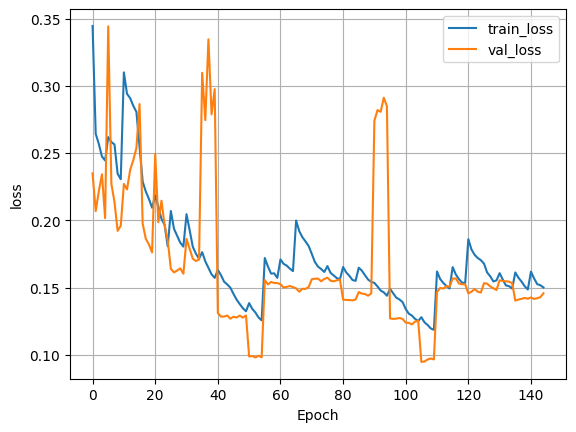

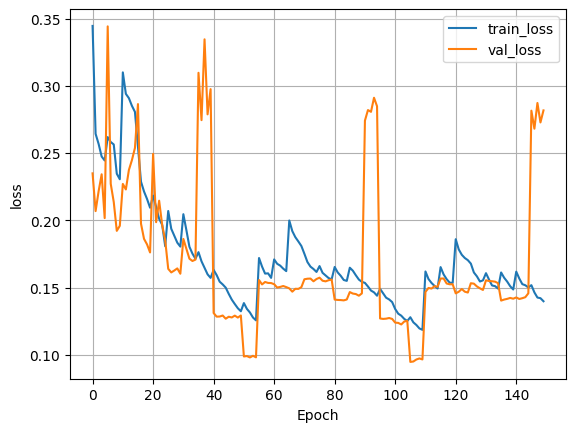

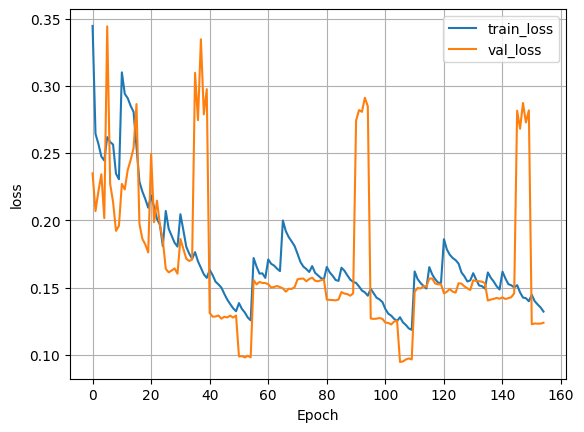

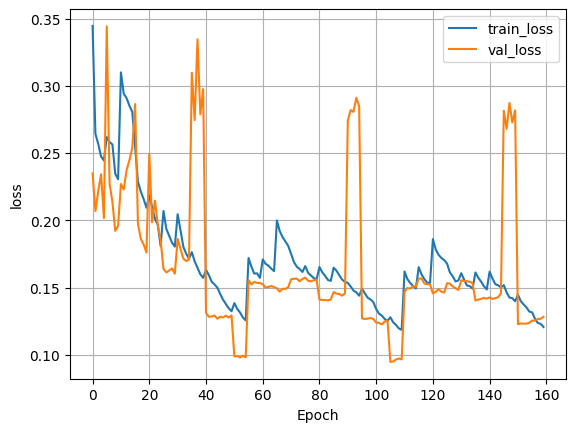

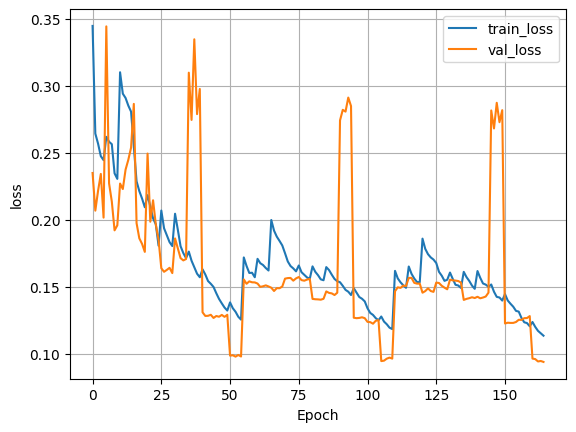

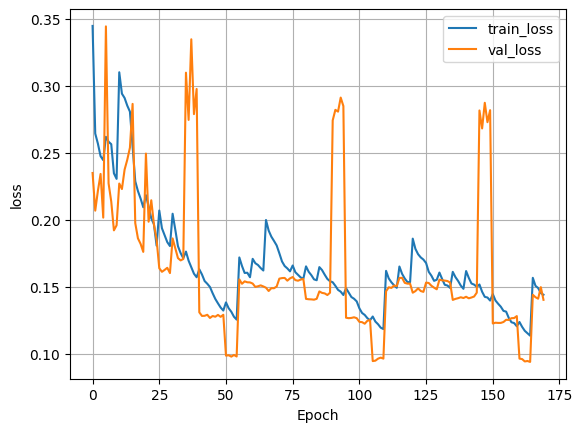

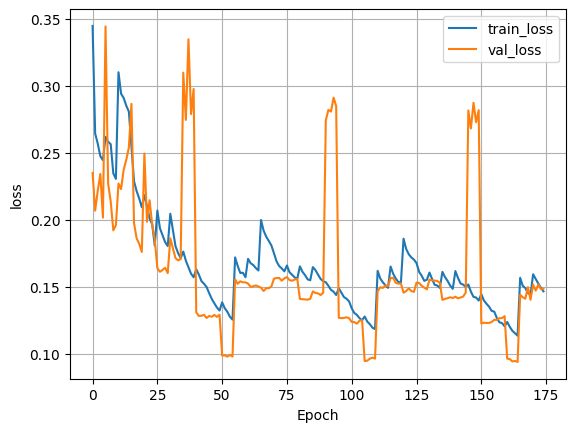

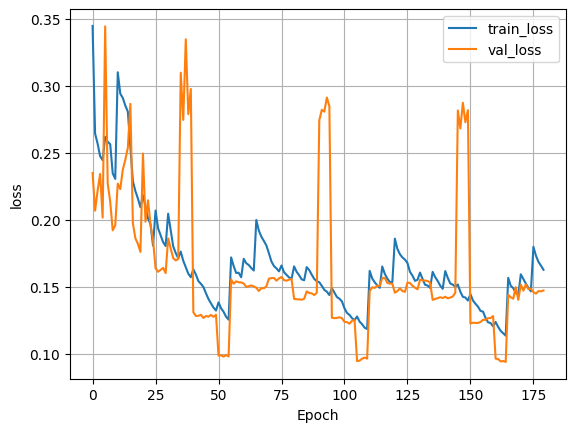

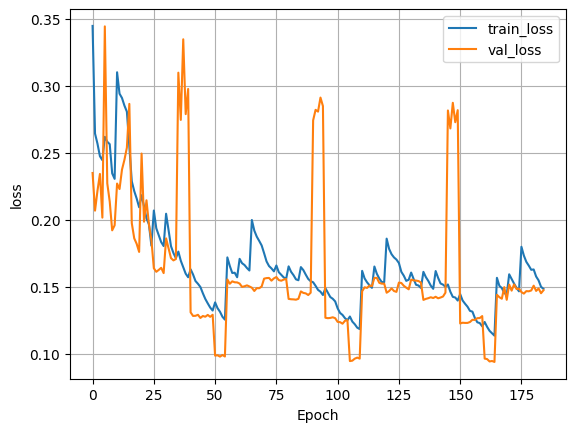

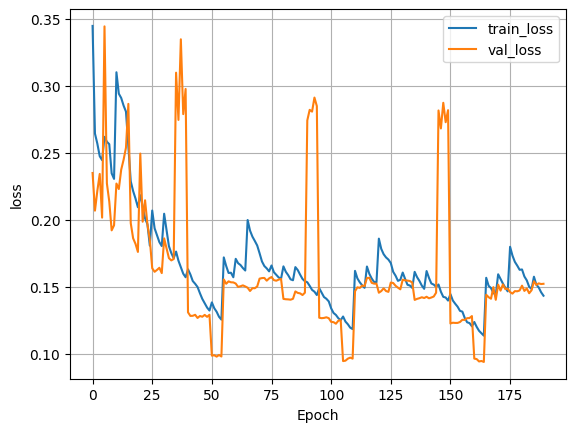

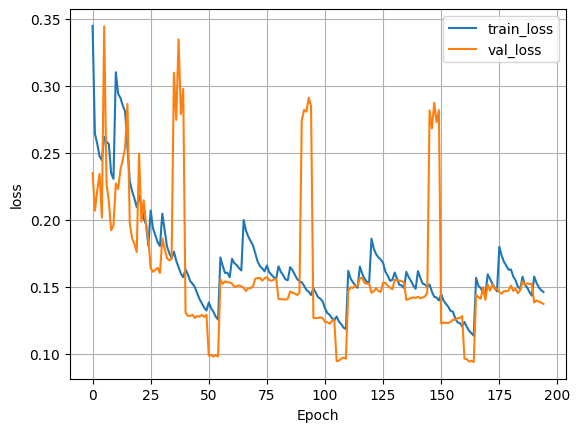

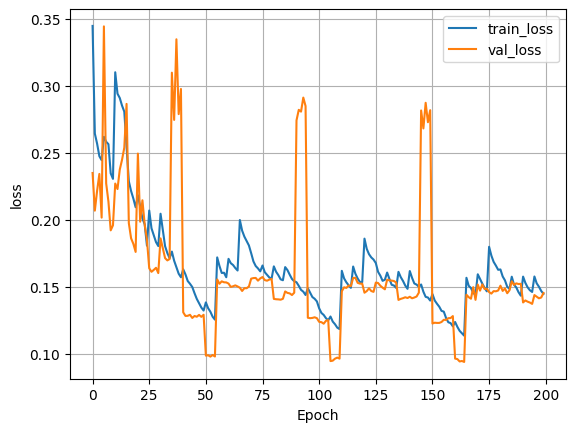

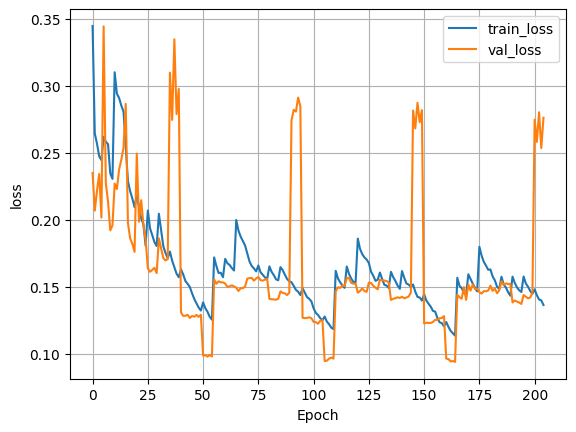

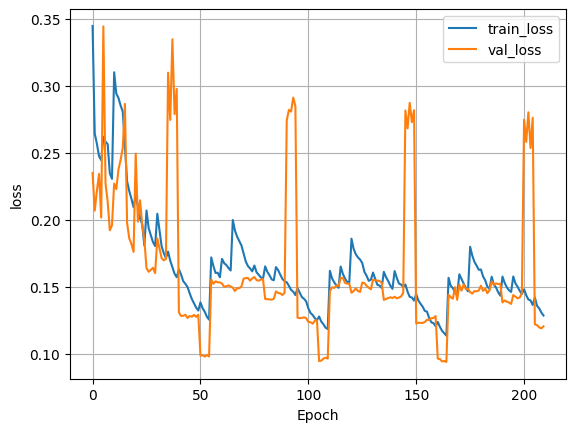

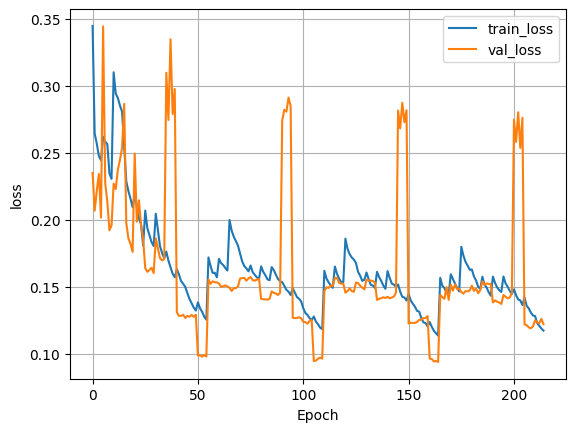

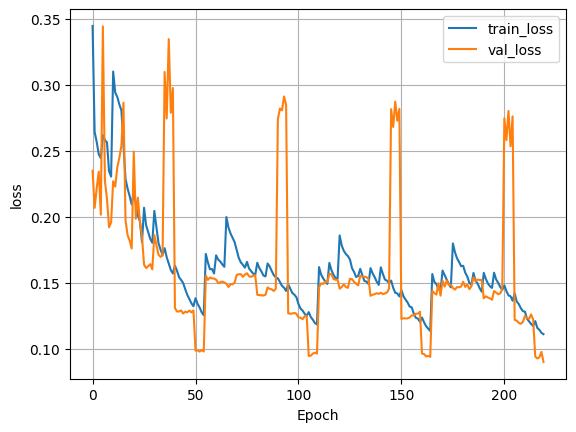

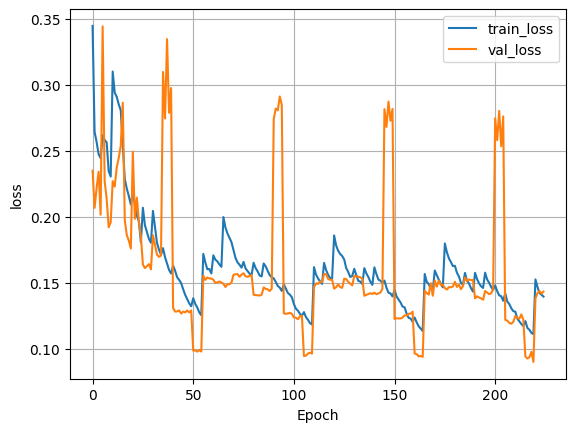

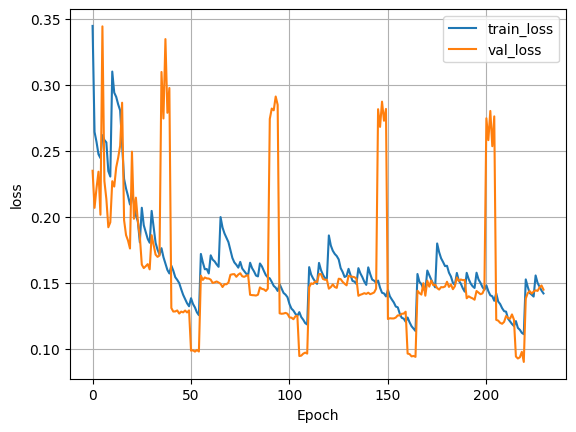

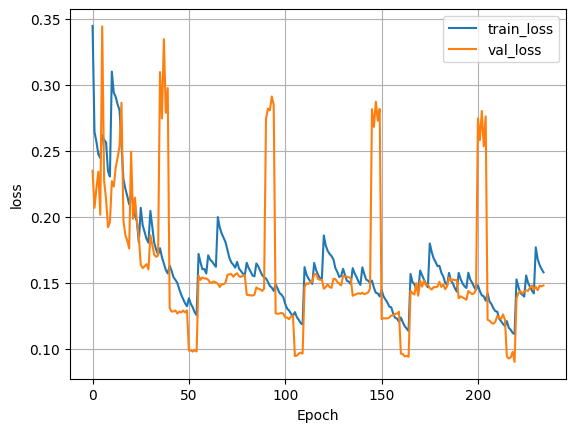

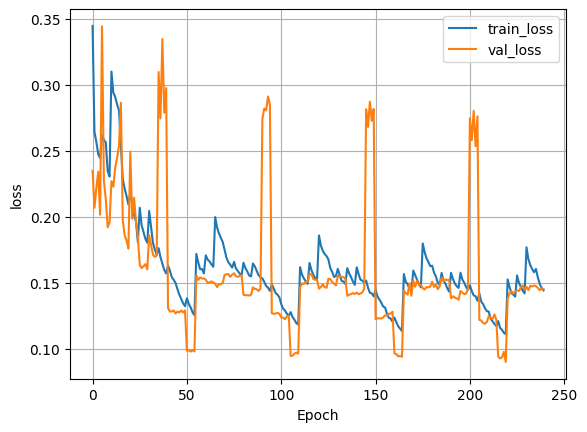

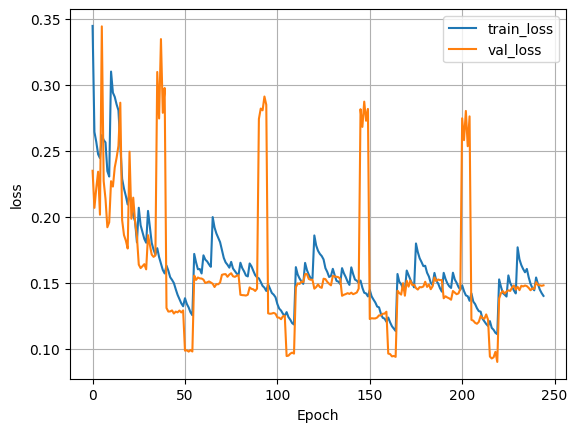

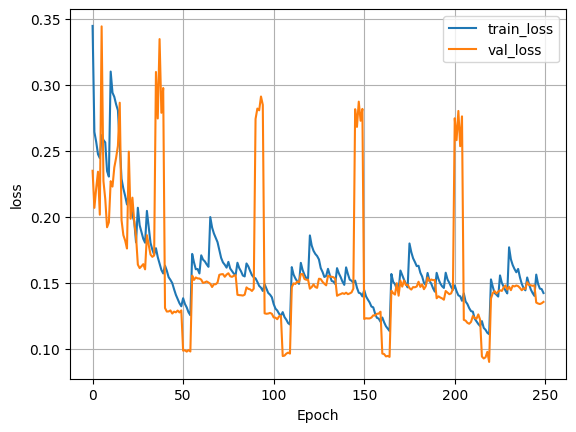

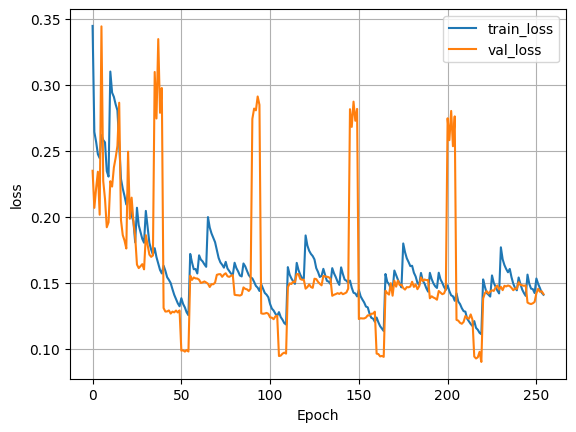

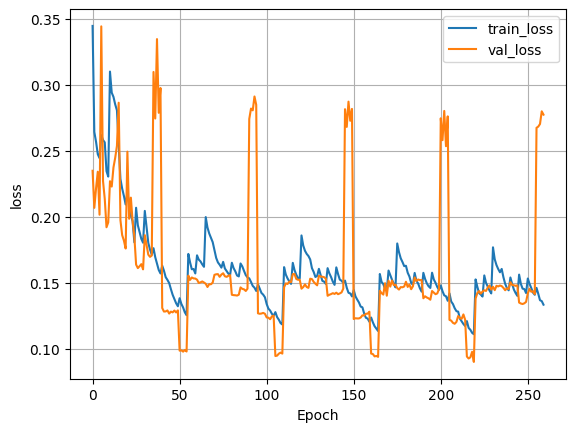

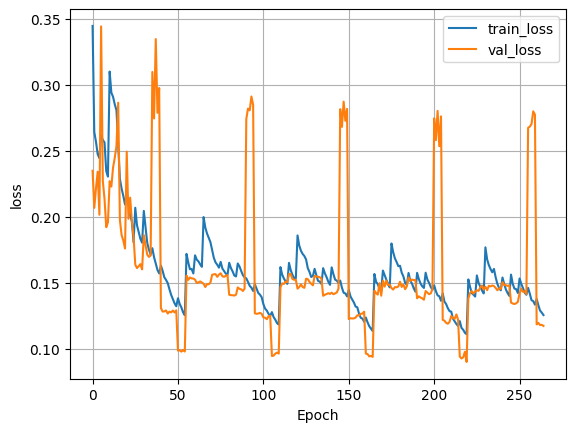

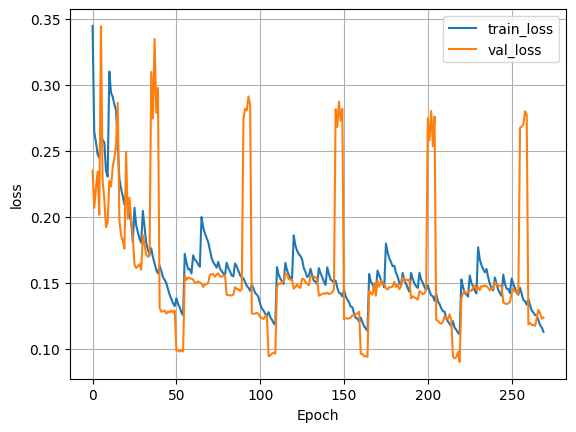

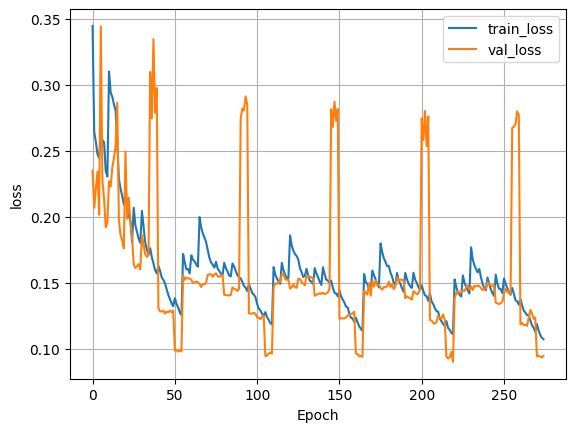

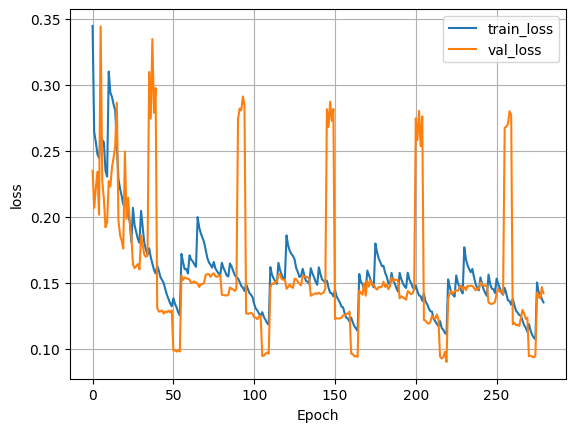

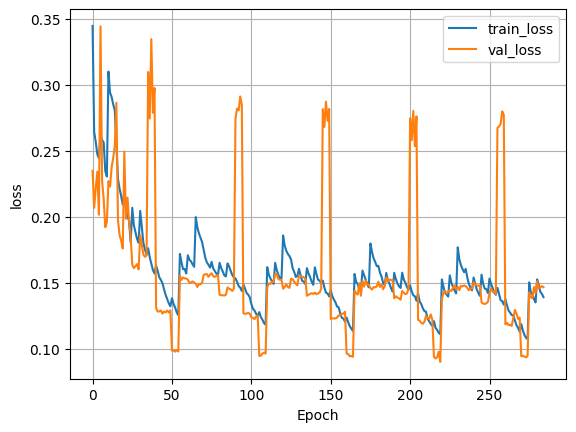

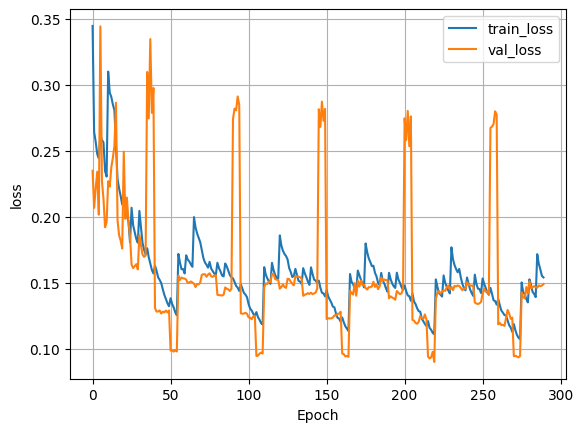

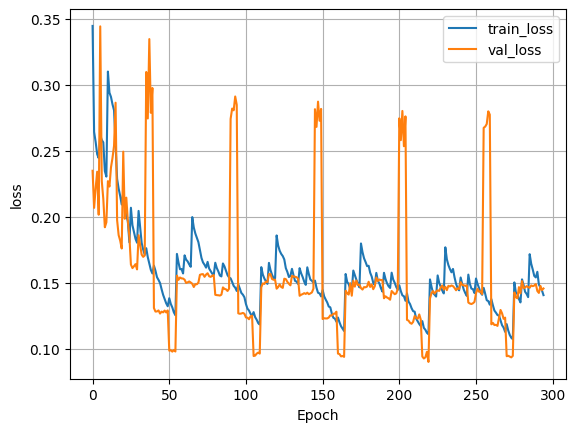

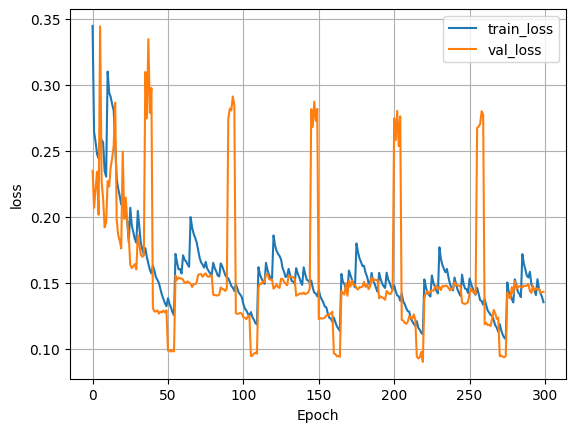

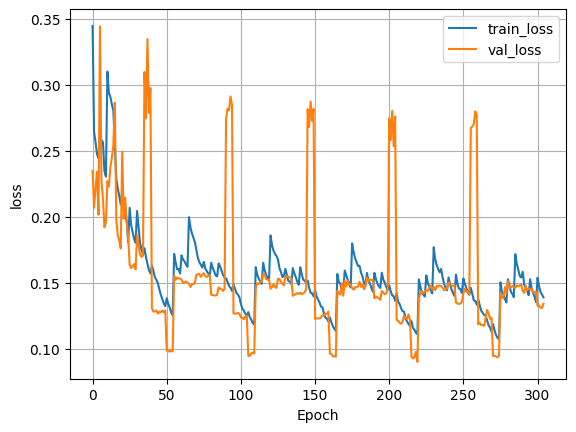

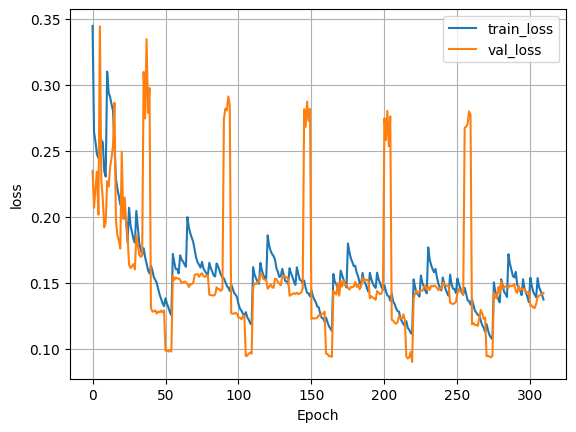

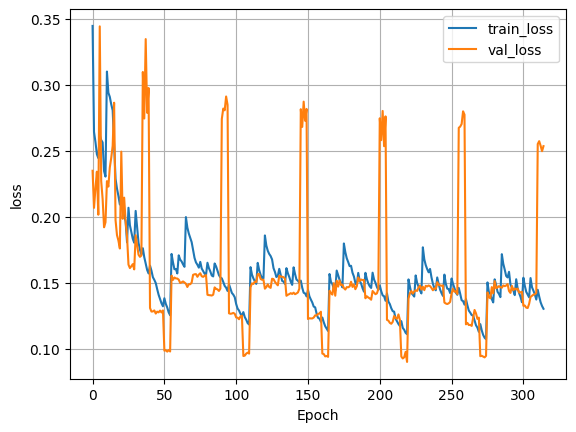

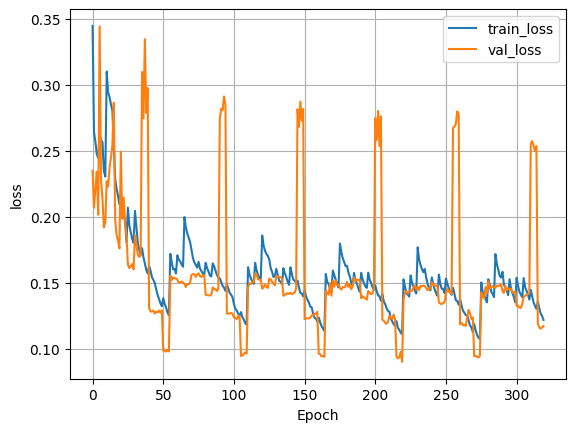

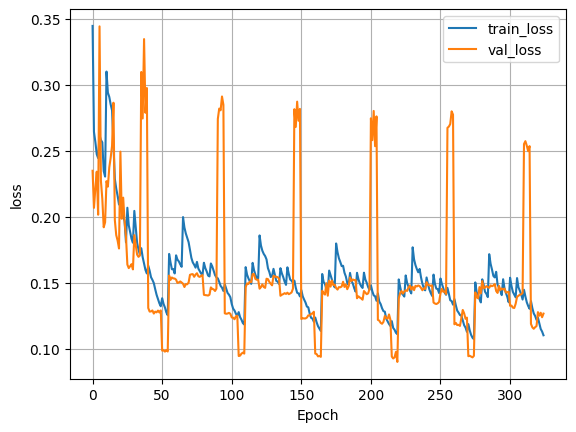

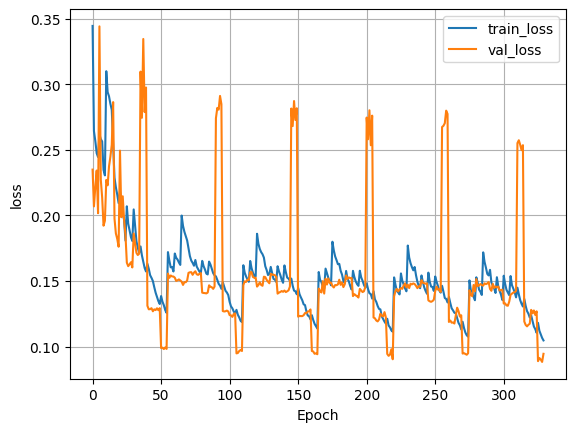

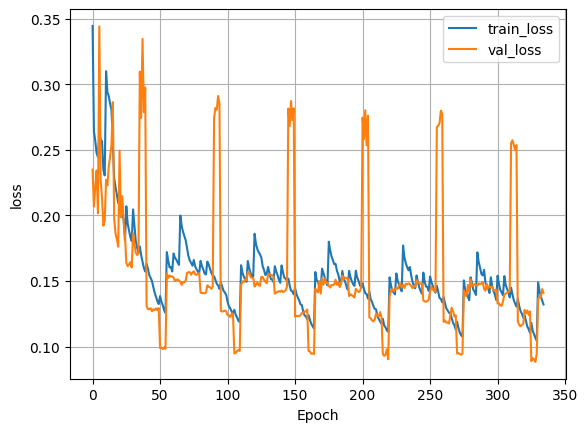

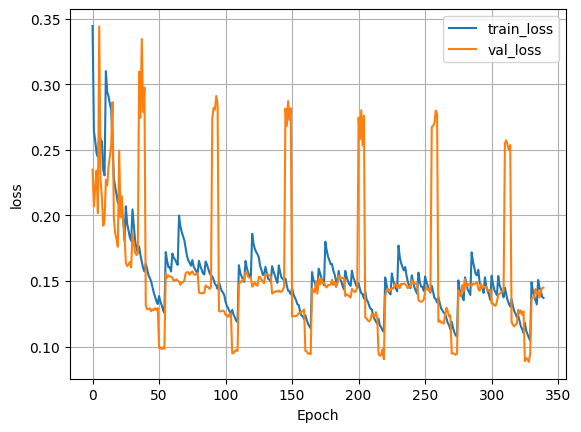

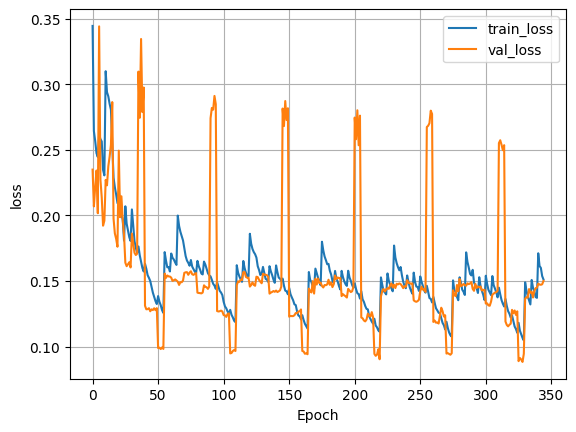

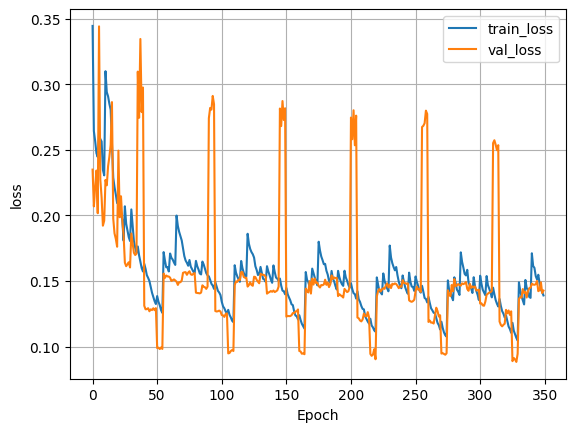

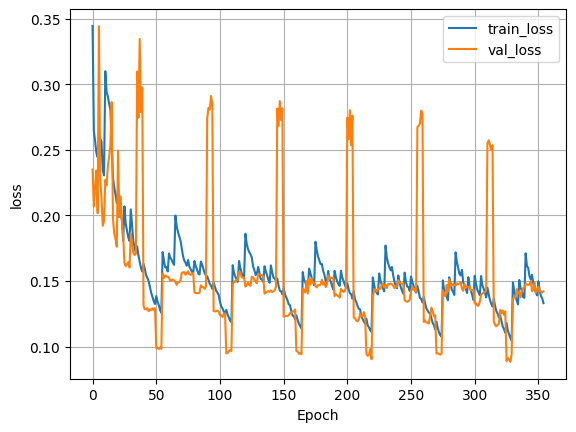

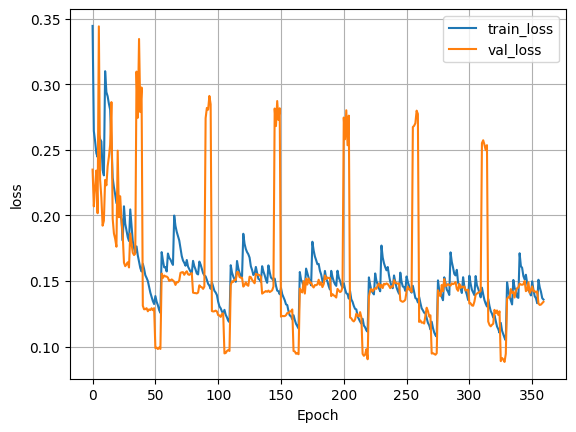

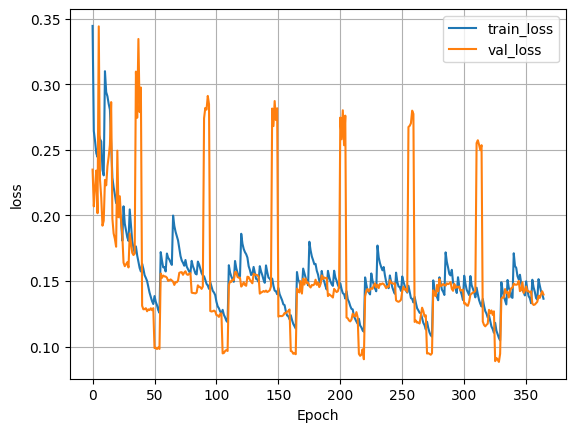

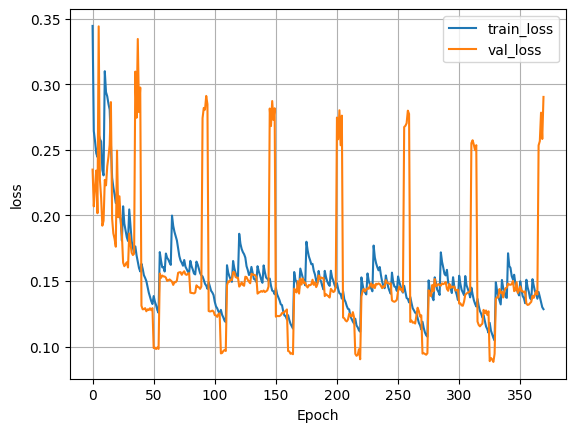

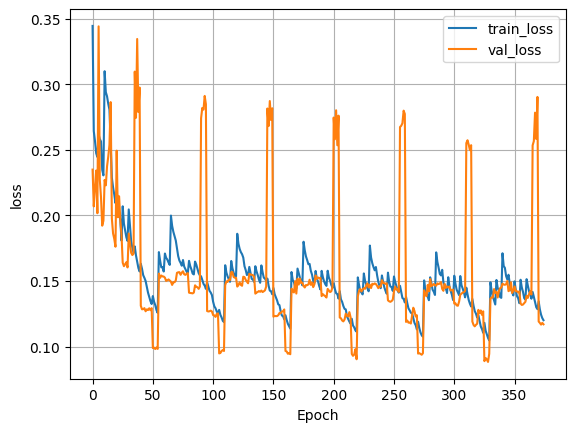

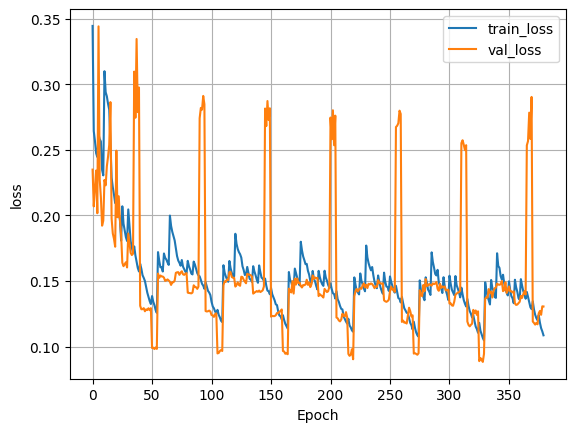

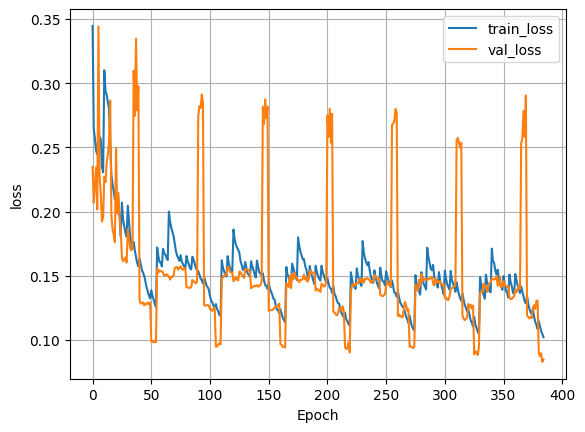

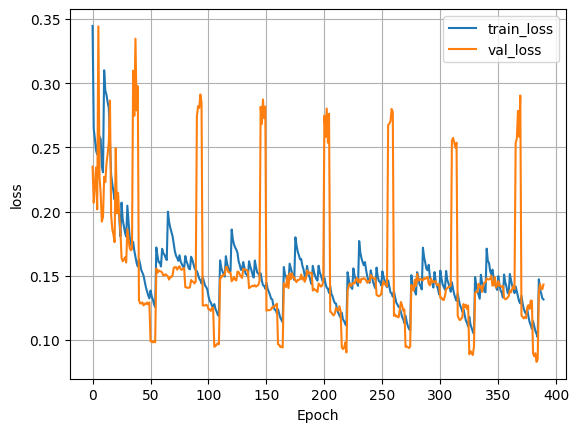

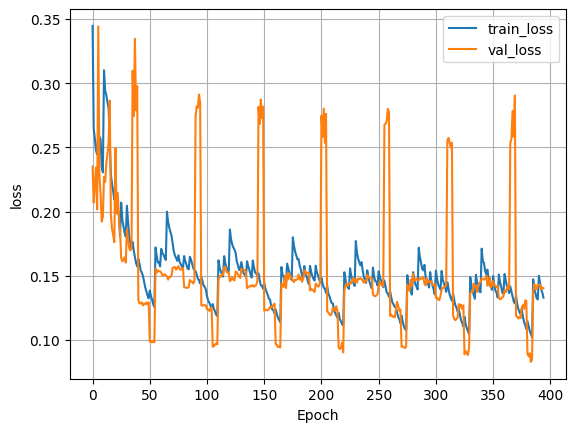

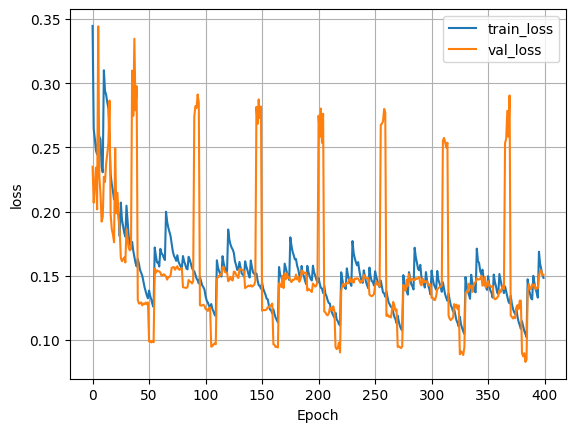

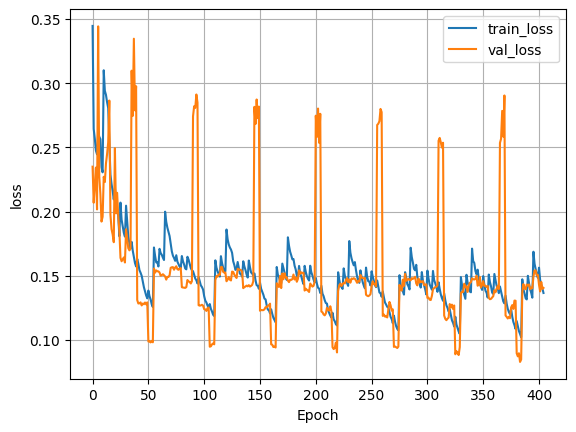

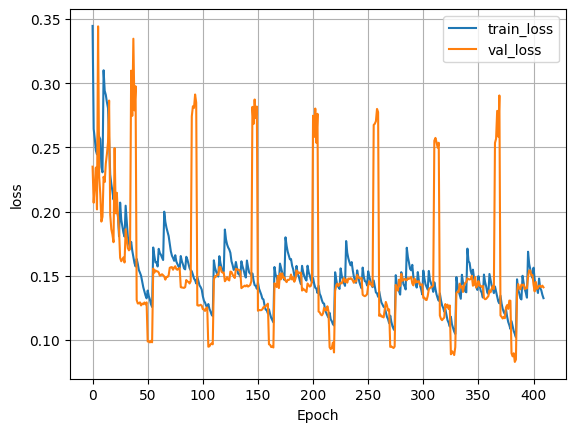

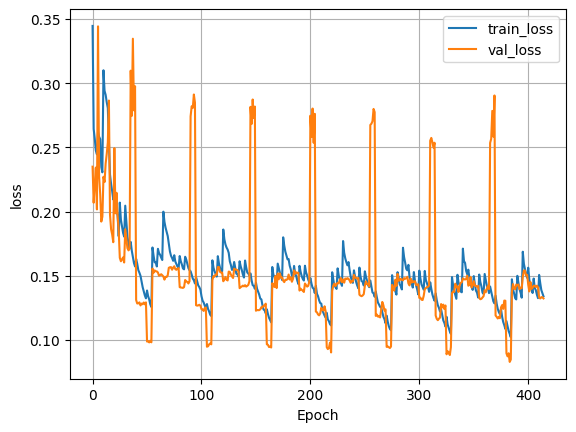

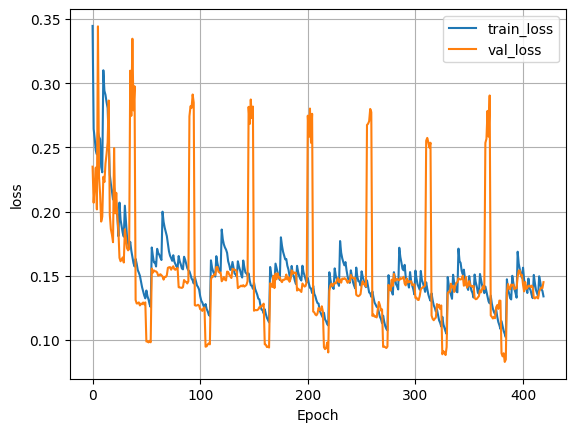

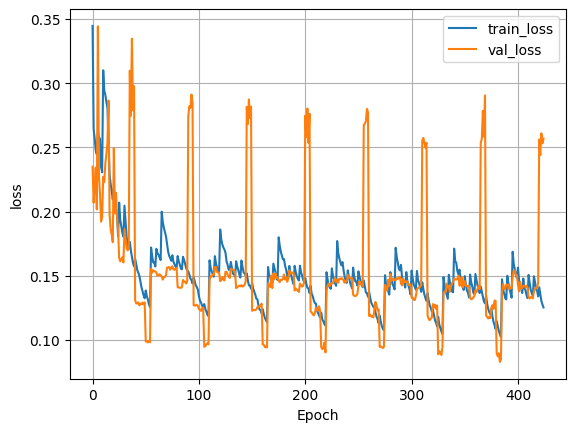

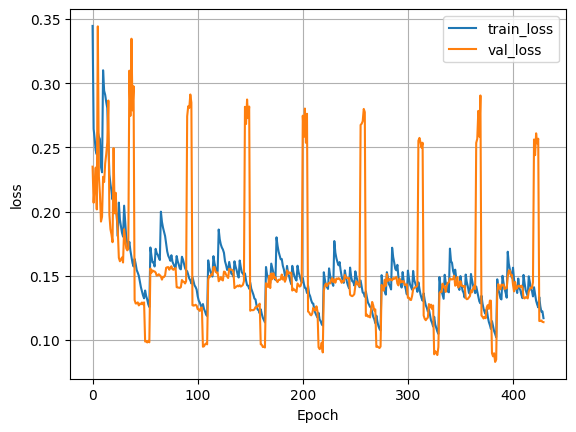

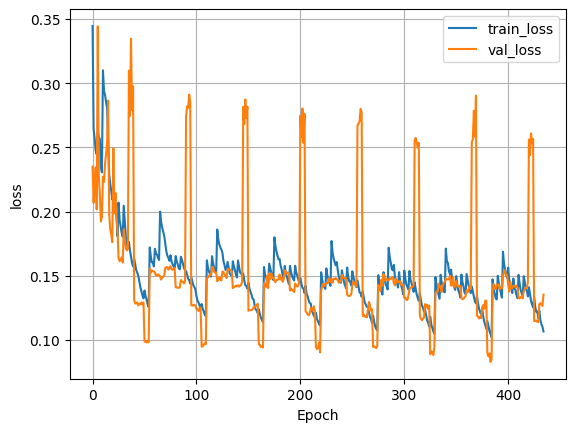

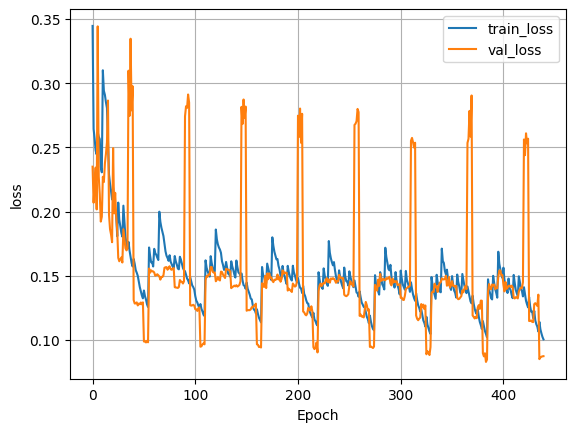

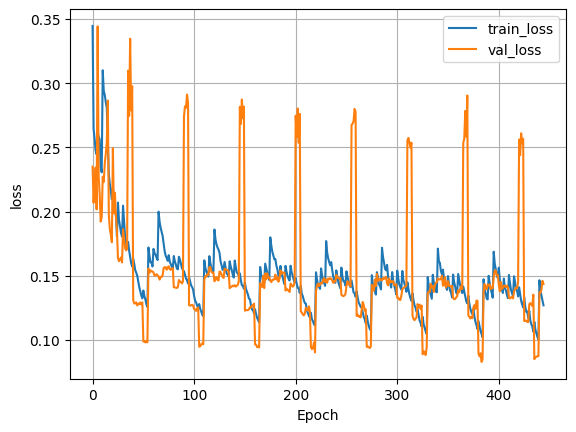

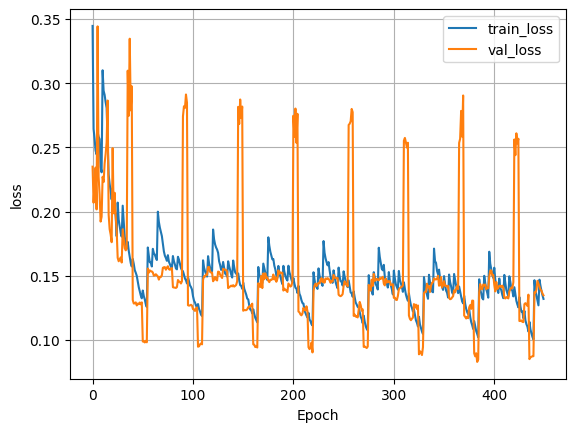

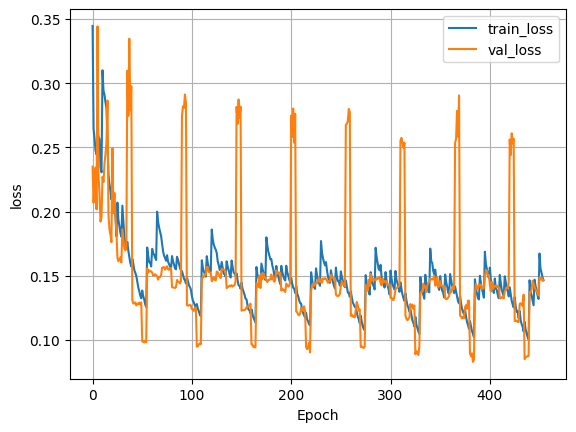

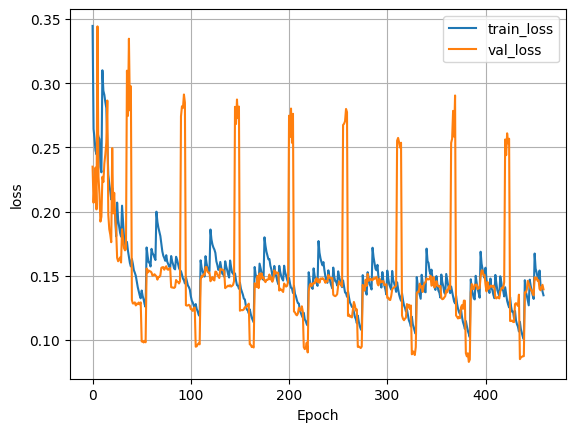

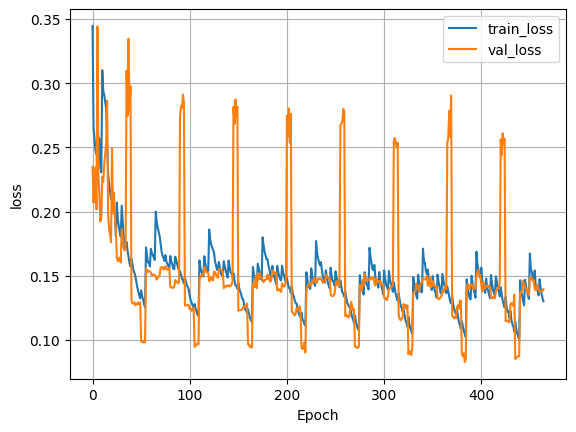

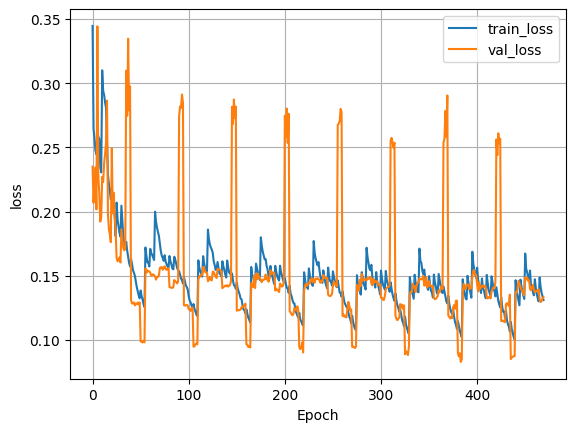

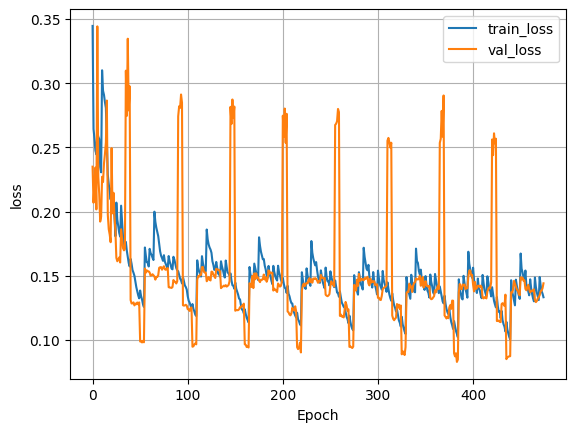

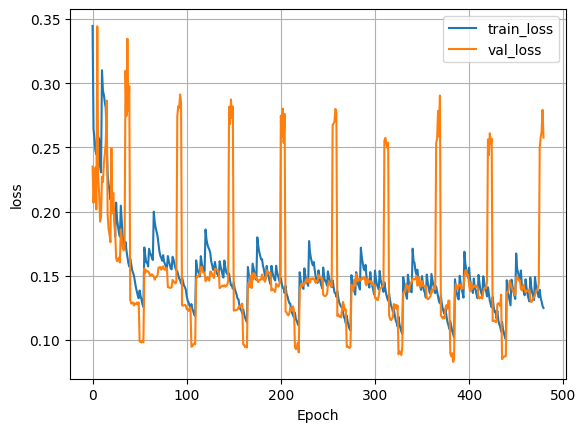

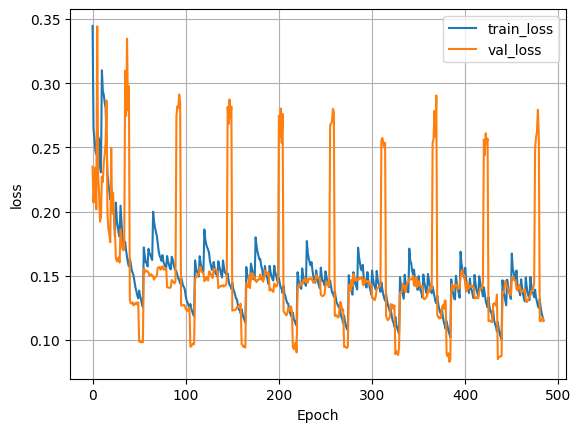

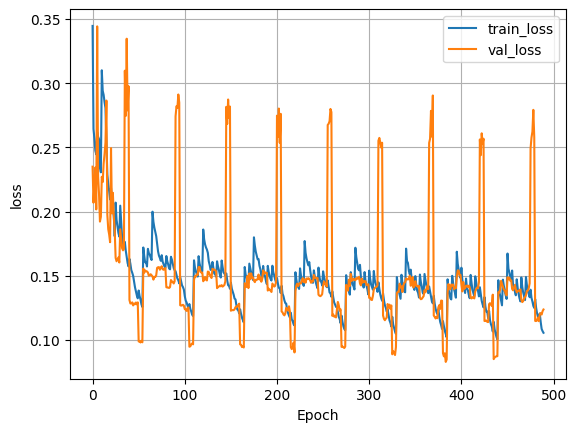

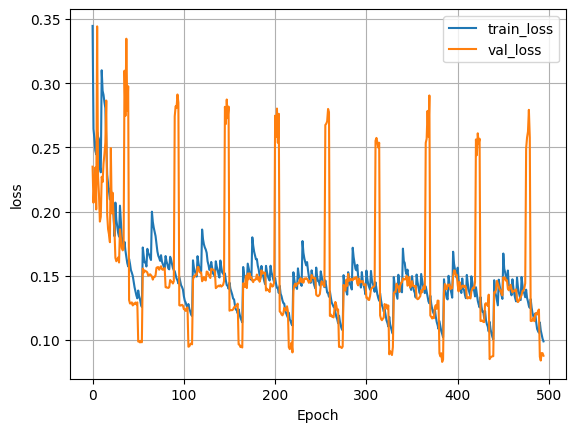

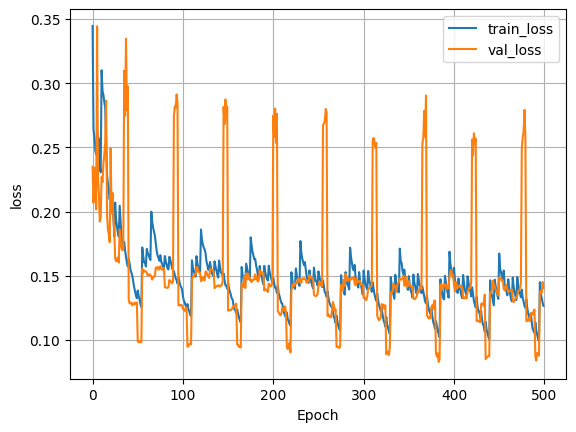

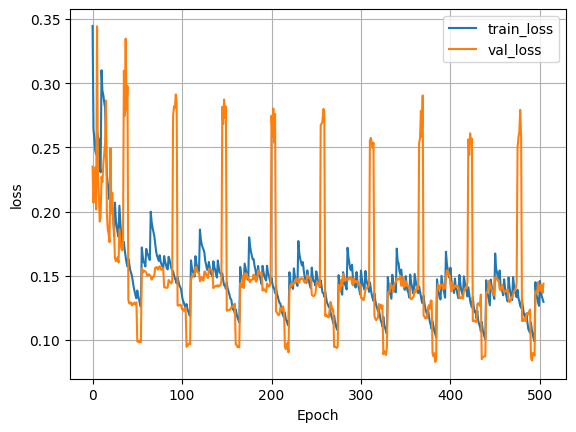

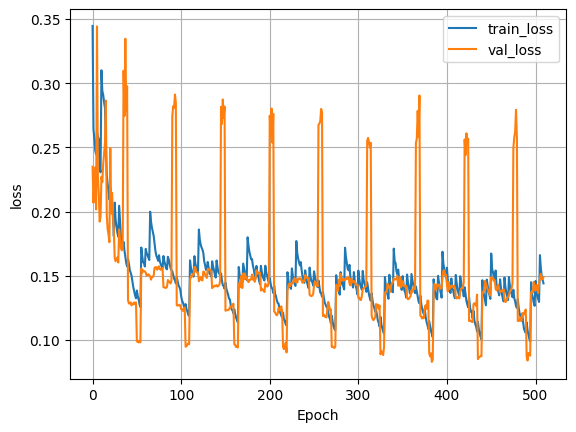

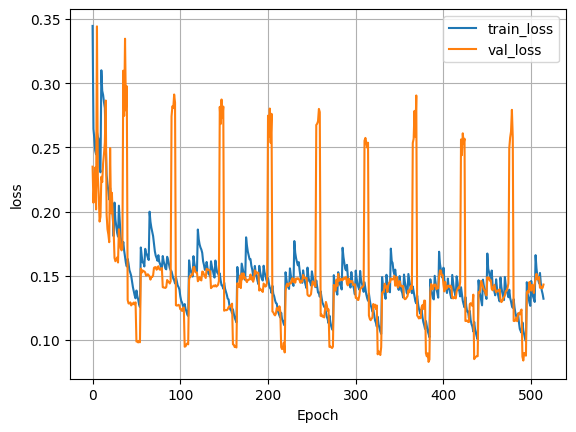

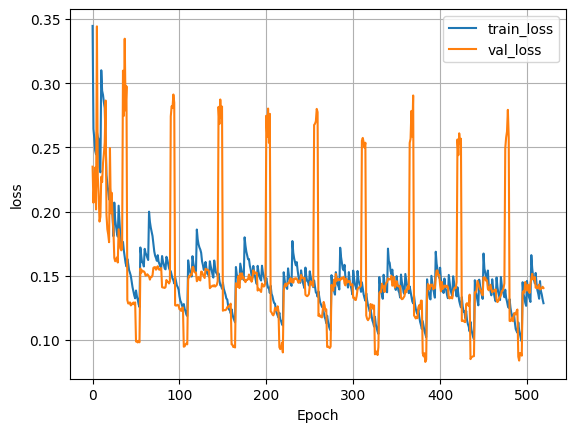

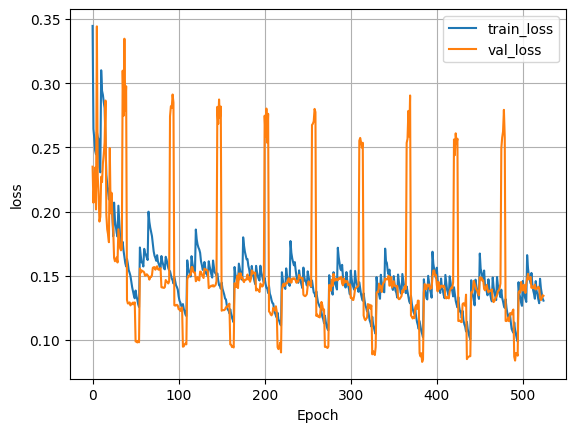

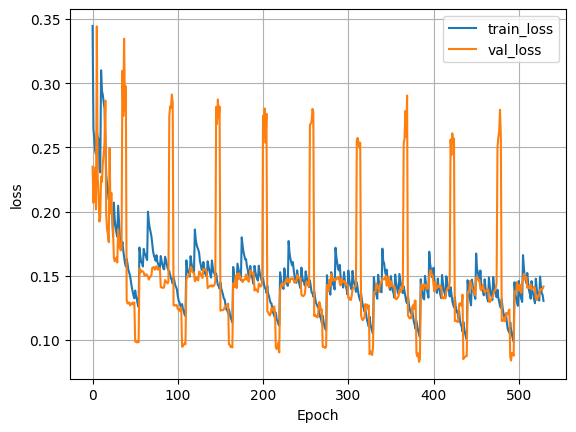

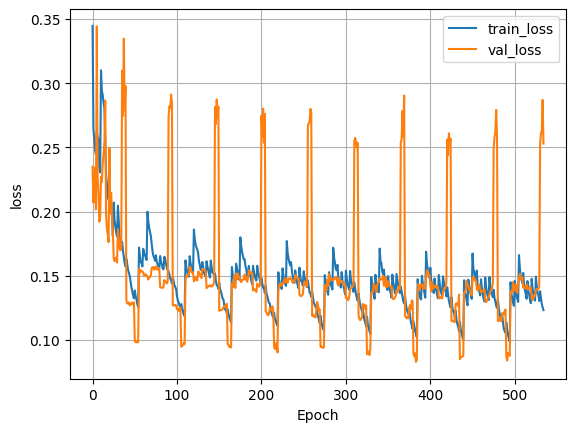

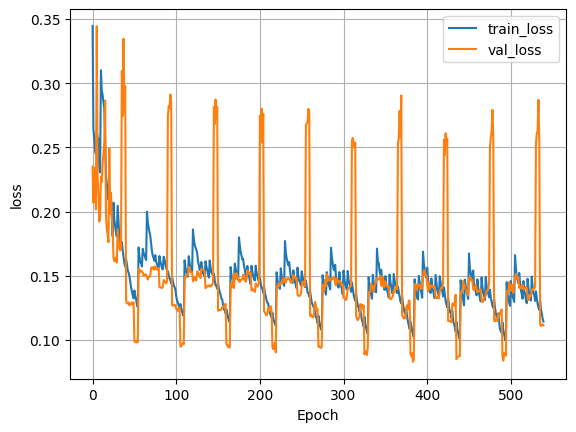

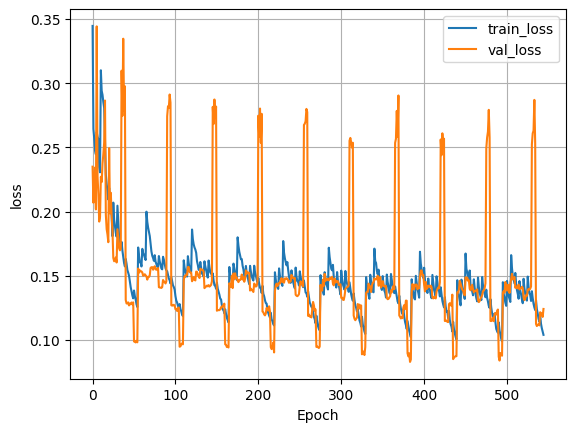

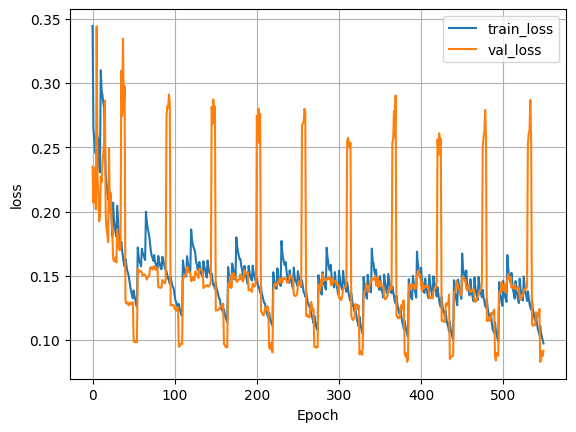

In [10]:
for i in range(10):
    for rng in learning_chuncks:
        data_manager =  YelpGraphDataModule(config, True, True, test_size=0.00, val_size=0.04, shuffle=False, start_data_load=rng[0] , end_data_load = rng[-1], device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
        data_manager.load_labels()
        data_manager.load_graphs()
        
        max_epochs = max_epochs + 5
        model_manager.fit(datamodule=data_manager, max_epochs=max_epochs)
        model_manager.save_plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'test[{i}]-range({rng[0]}-{rng[-1]})')
        model_manager.torch_model = model_manager.torch_model.to(device)
        model_manager.save_evaluation(data_manager.val_dataloader(), f'test[{i}]-range({rng[0]}-{rng[-1]})',True, True, True, True, True, True, True, multi_class=True)

In [27]:
from os import path

In [30]:
learning_chuncks = [range(int(5e4)-5000,int(5e4+1)+5000), range(int(1e5)-5000, int(1e5+1)+5000), range(int(1.5e5)-5000, int(1.5e5+1)+5000), range(int(2e5)-5000, int(2e5+1)+5000), range(int(2.5e5)-5000, int(2.5e5+1)+5000), range(int(3e5)-5000, int(3e5+1)+5000), range(int(3.5e5)-5000, int(3.5e5+1)+5000), range(int(4e5)-5000, int(4e5+1)+5000), range(int(4.5e5)-5000, int(4.5e5+1)+5000), range(int(5e5)-5000, int(5e5+1)+5000), range(int(5.6e5)-3000, int(5.6e5+1)+3000)]

In [31]:
learning_chuncks

[range(45000, 55001),
 range(95000, 105001),
 range(145000, 155001),
 range(195000, 205001),
 range(245000, 255001),
 range(295000, 305001),
 range(345000, 355001),
 range(395000, 405001),
 range(445000, 455001),
 range(495000, 505001),
 range(557000, 563001)]

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 10/10 [03:00<00:00, 18.06s/it]


self.shuffle: False
bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_Yelp_1\version_0\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=580` reached.


AttributeError: 'DataLoader' object has no attribute 'log_dir'

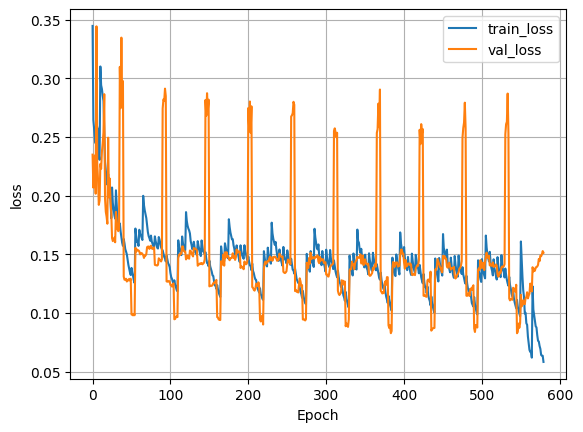

In [32]:
for i in range(1):
    for rng in learning_chuncks:
        data_manager =  YelpGraphDataModule(config, True, True, test_size=0.00, val_size=0.2, shuffle=False, start_data_load=rng[0] , end_data_load = rng[-1], device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
        data_manager.load_labels()
        data_manager.load_graphs()
        
        max_epochs = max_epochs + 15
        model_manager.fit(datamodule=data_manager, max_epochs=max_epochs)
        model_manager.save_plot_csv_logger(loss_names=['train_loss', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc_epoch'], name_prepend=f'test[{i}]-range({rng[0]}-{rng[-1]})')
        model_manager.torch_model = model_manager.torch_model.to(device)
        save_evaluation(data_manager.val_dataloader(), f'test[{i}]-range({rng[0]}-{rng[-1]})',True, True, True, True, True, True, True, multi_class=False)

In [48]:

from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
           
def save_evaluation(model, eval_dataloader, name_prepend: str='',
                give_confusion_matrix: bool=True, 
                give_report: bool=True, 
                give_f1_score: bool=False, 
                give_accuracy_score: bool=False, 
                give_precision_score: bool=False, 
                give_recall_score: bool=False, 
                give_hinge_loss: bool=False,
                multi_class: bool=False
                ):
        test_metrics_path = path.join(r'logs\hetero_model_Yelp_1\version_0\checkpoints', f'{name_prepend}_test_metrics.txt')
        y_true = []
        y_pred = []
        model.eval()
        for X, y in eval_dataloader:
            with torch.no_grad():
                y_p = model(X.to(device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'precision_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'precision_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'recall_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'recall_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)


In [45]:
data_manager =  YelpGraphDataModule(config, True, True, test_size=0.00, val_size=0.02631578947368421052631578947368, shuffle=False, start_data_load=550000 , end_data_load = 598000, device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

save_evaluation(model_manager, data_manager.train_dataloader(), f'test',True, True, True, True, True, True, True, multi_class=False)

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/Yelp\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 48/48 [14:09<00:00, 17.71s/it]


self.shuffle: False
torch.Size([38401, 1])
torch.Size([38401, 1])
torch.Size([38401, 1])
torch.Size([38401, 1])


In [51]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 1, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights)
graph_embedding = graph_embedding.to(device)
# HeteroBinaryLightningModel(graph_embedding,
#                                     optimizer=optimizer,
#                                     loss_func=loss_func,
#                                     learning_rate=0.045,
#                                     batch_size=batch_size,
#                                     user_lr_scheduler=True,
#                                     lr_scheduler=lr_scheduler,
#                                     min_lr=0.0005
#                                     ).to(device)
lightning_model = HeteroBinaryLightningModel.load_from_checkpoint(r'logs\hetero_model_Yelp_1\version_0\checkpoints\epoch=546-step=104075.ckpt', model=graph_embedding, num_classes=1)
lightning_model.eval()
# lightning_model.model.to(device)

# model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(lightning_model.model.to(device), data_manager.val_dataloader(), f'epoch-{546}',True, True, True, True, True, True, True, multi_class=False)

c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding6.py:59: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([38401, 1])
torch.Size([38401, 1])
torch.Size([38401, 1])
torch.Size([38401, 1])


In [ ]:
graph_embedding = HeteroDeepGraphEmbedding6(300, 4, X3.metadata(), 32, dropout=0.2, edge_type_count=11, edge_type_weights=[1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.])
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_Yelp_1\version_0\checkpoints\epoch=381-step=72650.ckpt', model=graph_embedding, num_classes=4)
lightning_model.eval()
lightning_model.model.edge_type_weights
lightning_model.model.pw1 
# lightning_model()

In [36]:
path.join(model_manager.log_dir, model_manager.log_name, f'version_{model_manager.logger.version}', f'{"121"}_test_metrics.txt')

'logs/hetero_model_Yelp_1\\version_0\\121_test_metrics.txt'

In [35]:
save_evaluation(model_manager, data_manager.val_dataloader(), f'test[{i}]-range({rng[0]}-{rng[-1]})',True, True, True, True, True, True, True, multi_class=False)

torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000, 1])
torch.Size([2000, 1])


In [ ]:
save_evaluation(data_manager.val_dataloader(), f'test[{i}]-range({rng[0]}-{rng[-1]})',True, True, True, True, True, True, True, multi_class=False)

In [11]:
max_epochs

550

In [12]:
model_manager.trainer.save_checkpoint(r'logs\hetero_model_Yelp_1\version_0\checkpoints\epoch=550.ckpt')

In [15]:
torch.save(model_manager.trainer.model.model, r'logs\hetero_model_Yelp_1\version_0\checkpoints\epoch=550.pt')

In [ ]:
model_manager.trainer.model.save(r'r'logs\hetero_model_Yelp_1\version_0\checkpoints\')

In [12]:
t_dataloader = data_manager.train_dataloader()
X1, Y1 = next(iter(t_dataloader))

In [21]:
graph_embedding(X1)[0].shape

torch.Size([256, 2])

In [18]:
X1.x_dict['dep']

tensor([ 0,  1,  2,  ..., 42, 43, 44])

In [12]:
max_epochs = max_epochs + 5
model_manager.fit(datamodule=data_manager, max_epochs=max_epochs)
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'test[{i}]-range({rng[0]}-{rng[-1]})')
model_manager.torch_model = model_manager.torch_model.to(device)
model_manager.save_evaluation(data_manager.val_dataloader(), f'test[{i}]-range({rng[0]}-{rng[-1]})',True, True, True, True, True, True, True, multi_class=True)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | HeteroLoss2               | 0     
2 | train_acc | BinaryAccuracy            | 0     
3 | val_acc   | BinaryAccuracy            | 0     
4 | test_acc  | BinaryAccuracy            | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)


bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.


Training: |          | 0/? [00:00<?, ?it/s]

RuntimeError: shape '[256, 2]' is invalid for input of size 1024

In [4]:
graph_type = TextGraphType.SENTIMENT
data_manager = AGGraphDataModule(config, True, True, test_size=0.00, val_size=0.05511811, shuffle=False, start_data_load=0 , end_data_load = 127000 , device='cpu', batch_size=batch_size, graph_type=graph_type, load_preprocessed_data = True)
data_manager.load_labels()
data_manager.load_graphs()

filename: C:\Users\fardin\Projects\ColorIntelligence\data/GraphData/AG\sentiment\graph_var.txt


 Loding Graphs From File : 100%|██████████| 127/127 [16:04<00:00,  7.60s/it]


In [13]:
data_manager.update_batch_size(256)

In [5]:
val_dataloader = data_manager.val_dataloader()
X3, Y3 = next(iter(val_dataloader))

In [6]:
len(val_dataloader)

55

In [7]:
from copy import copy
metadata = copy(X3.metadata())

In [8]:

edge_type_weights = {
    # 'full': [1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.],
    'full-non-sentiment': [1., 1., 1., 1., 1., 1., 1., 1., 1., 0., 0.],
    # 'seq': [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'dep': [1., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
    # 'tag': [0., 0., 1., 1., 1., 0., 0., 0., 0., 0., 0.],
    # 'general_sentence': [0., 0., 0., 0., 1., 1., 1., 1., 1., 0., 0.],
    # 'sentence': [0., 0., 0., 0., 1., 0., 0., 1., 1., 0., 0.],
    # 'sentiment': [0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 1.],
}
# type_checkpoint = {
#     #  'dep': r'logs\hetero_model_14_AG\version_0\checkpoints\epoch=38-step=17199.ckpt',
#      'tag': r'logs\hetero_model_15_AG_tag\version_0\checkpoints\epoch=9-step=4410.ckpt',
#      'general_sentence': '',
#      'sentence': '',
# }

In [9]:
# edge_type_weights = {
#     'seq_gen': [1, 1, 1],
#     'seq': [0, 0, 1]
# }
# type_checkpoint = {
#     'seq_gen': r'logs\hetero_model_12_AG\version_1\checkpoints\epoch=24-step=11025.ckpt',
#     'seq': r'logs\hetero_model_12_AG\version_2\checkpoints\epoch=22-step=10143.ckpt'
# }

In [10]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        model_mgr.lightning_model.eval()
        model_mgr.lightning_model.model.eval()
        model_mgr.torch_model.eval()
        for X, y in eval_dataloader:
            model_mgr.trainer.model.eval()
            with torch.no_grad():
                y_p = model_mgr.trainer.model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)


In [14]:
for k in edge_type_weights:
    graph_embedding = HeteroDeepGraphEmbedding5(300, 4, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights[k])
    graph_embedding = graph_embedding.to(device)
    # callbacks = [
    # ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    # ]
    
    
    # loss_func = MulticlassHeteroLoss2(exception_keys=['word'], enc_factor=0.0002)
    # optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.0012)
    # lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 10, 20, 35], gamma=0.6, verbose=True)
    # lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
    #                                     optimizer=optimizer,
    #                                     loss_func=loss_func,
    #                                     learning_rate=0.0045,
    #                                     batch_size=batch_size,
    #                                     user_lr_scheduler=True,
    #                                     lr_scheduler=lr_scheduler,
    #                                     min_lr=0.0005
    #                                     ).to(device)
    # lightning_model.model.to(device)
          
    # model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_18_AG',device=device, num_train_epoch=70)
    flopt_counter = FlopCounterMode(graph_embedding)
    with flopt_counter:
        graph_embedding(X3.to(device))
    # model_manager.draw_summary(data_manager.val_dataloader())
    # model_manager.fit(datamodule=data_manager, ckpt_path=r'logs\hetero_model_18_AG\version_8\checkpoints\epoch=38-step=18252.ckpt')
    
    # model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
    # model_manager.torch_model = model_manager.torch_model.to(device)
    # save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

c:\Users\fardin\Projects\ColorIntelligence\Scripts\Models\GraphEmbedding\HeteroDeepGraphEmbedding5.py:55: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)


Module                                        FLOP    % Total
---------------------------------------  ---------  ---------
HeteroDeepGraphEmbedding5                1928.540M    100.00%
 - aten.addmm                            1920.271M     99.57%
 - aten.mm                                  6.884M      0.36%
 - aten.convolution                         0.081M      0.00%
 - aten.bmm                                 1.303M      0.07%
 HeteroDeepGraphEmbedding5.hetero_gat_1  1737.993M     90.12%
  - aten.addmm                           1734.682M     89.95%
  - aten.mm                                 3.311M      0.17%
 HeteroDeepGraphEmbedding5.hetero_gat_2   188.344M      9.77%
  - aten.addmm                            185.033M      9.59%
  - aten.mm                                 3.311M      0.17%
 HeteroDeepGraphEmbedding5.mem_pool         1.646M      0.09%
  - aten.convolution                        0.081M      0.00%
  - aten.bmm                                1.303M      0.07%
  - aten

In [22]:

import torch.nn.functional as F
from torch import Tensor
import torch
from torch.nn import Linear
from torch_geometric.nn import BatchNorm, MemPooling, to_hetero, PairNorm
from torch_geometric.data import HeteroData
from Scripts.Models.BaseModels.HeteroGat import HeteroGat
from Scripts.Models.BaseModels.HeteroLinear import HeteroLinear


class HeteroDeepGraphEmbedding6(torch.nn.Module):
    
    def __init__(self,
                 input_feature: int, out_features: int,
                 metadata,
                 hidden_feature: int=256,
                 device = 'cpu',
                 dropout=0.1,
                 edge_type_count=9,
                 edge_type_weights=-1,
                 active_keys = ['dep', 'tag', 'word', 'sentence', 'general', 'sentiment'],
                 num_pooling_classes=1
                 ):

        super(HeteroDeepGraphEmbedding6, self).__init__()
        self.input_features = input_feature
        self.num_out_features = out_features
        self.hidden_feature: int = hidden_feature
        self.edge_type_count = edge_type_count
        self.edge_type_weights = torch.nn.Parameter(torch.tensor([1]* self.edge_type_count if edge_type_weights==-1 else  edge_type_weights).to(torch.float32), requires_grad=False)

        self.part_weight_norm = torch.nn.LayerNorm((self.edge_type_count,))
        self.norm = PairNorm()
        self.drop = torch.nn.Dropout(0.2)
        self.active_keys = active_keys
        
        self.hetero_linear1 = to_hetero(HeteroLinear(self.input_features,self.hidden_feature, use_dropout=False, use_batch_norm=True), metadata)
        
        self.hetero_gat_1 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        self.hetero_gat_2 = to_hetero(HeteroGat(self.hidden_feature, self.hidden_feature, dropout, num_heads=2), metadata)
        
        self.hetero_linear_2 = to_hetero(HeteroLinear(self.hidden_feature, self.input_features, dropout, use_batch_norm=True), metadata)
        
        self.num_pooling_classes = torch.nn.Parameter(torch.tensor(num_pooling_classes).to(torch.int32), requires_grad=False)
        self.mem_pool = MemPooling(self.hidden_feature, self.hidden_feature, 2, self.num_pooling_classes)
        
        self.linear_1 = Linear(self.hidden_feature* self.num_pooling_classes, self.hidden_feature)
        self.linear_2 = Linear(self.hidden_feature, self.hidden_feature)
        self.batch_norm_1 = BatchNorm(self.hidden_feature)
        
        self.output_layer = Linear(self.hidden_feature, self.num_out_features)
        
        self.dep_embedding = torch.nn.Embedding(45, self.input_features)
        self.tag_embedding = torch.nn.Embedding(50, self.input_features)
        self.dep_unembedding = torch.nn.Linear(self.hidden_feature, 45)
        self.tag_unembedding = torch.nn.Linear(self.hidden_feature, 50)
        
        self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
        
        self.x_batches = None
        self.x_batches_cpu = None
        self.x_dict_cpu_1 = None
        self.x_dict_cpu_2 = None
        

    def forward(self, x: HeteroData) -> Tensor:
        self.x_batches = {k:x[k].batch for k in self.active_keys}
        # self.x_batches_cpu = {k:self.x_batches[k].to('cpu') for k in self.active_keys}
        x_dict, edge_attr_dict, edge_index_dict = self.preprocess_data(x)
        edge_attr_dict = self.update_weights(edge_attr_dict, self.pw1)
        x_dict = self.hetero_linear1(x_dict)
        x_dict = self.hetero_gat_1(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_1 = {k: x_dict[k].to('cpu') for k in x_dict}
        self.normalize(x_dict, self.x_batches)
        x_dict = self.hetero_gat_2(x_dict, edge_index_dict, edge_attr_dict)
        # self.x_dict_cpu_2 = {k: x_dict[k].to('cpu') for k in x_dict}
        x_pooled, S = self.mem_pool(x_dict['word'], self.x_batches['word'])
                
        x_pooled = x_pooled.view(x_pooled.shape[0], -1)
        x_pooled = F.relu(self.linear_1(x_pooled))
        x_pooled = F.relu(self.batch_norm_1(self.linear_2(x_pooled)))
        out = self.output_layer(x_pooled)
        
        x_dict_out = self.hetero_linear_2(x_dict)
        x_dict_out['dep'] = self.dep_unembedding(x_dict['dep'])
        x_dict_out['tag'] = self.tag_unembedding(x_dict['tag'])
        
        return out, x_dict_out

    def preprocess_data(self, x):
        x_dict = {key: x.x_dict[key] for key in x.x_dict}
        if 'dep' in x_dict:
            x_dict['dep'] = self.dep_embedding(x_dict['dep'])
        if 'tag' in x_dict:
            x_dict['tag'] = self.tag_embedding(x_dict['tag'])

        edge_attr_dict = x.edge_attr_dict
        edge_index_dict = x.edge_index_dict

        return x_dict, edge_attr_dict, edge_index_dict

    def normalize(self, x_dict, x_batches):
        for k in self.active_keys:
            vecs = x_dict[k]
            if k not in x_batches:
                print('k is not in x_batches')
                continue
            batches = x_batches[k]
            if batches is None:
                print('batches is none')
                continue
            if len(batches) == 0:
                print('batches is empty')
                continue
            
            x_dict[k] = self.norm(vecs, batches)
        return x_dict

    def update_weights(self, edge_attr_dict, part_weights):
        for i, key in enumerate(edge_attr_dict):
            edge_attr = edge_attr_dict[key]
            if edge_attr is None or edge_attr == ('word', 'seq', 'word'):
                continue
            edge_attr_dict[key]= edge_attr * part_weights[i]
        return edge_attr_dict

    def get_scale_same(self, scale:float, attributes: Tensor):
        if attributes is None or len(attributes) == 0:
            return
        attributes = scale * torch.ones_like(attributes)
        return attributes

C:\Users\fardin\AppData\Local\Temp\ipykernel_16560\3676976156.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


Adjusting learning rate of group 0 to 4.5000e-03.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | MulticlassHeteroLoss2     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_wo

bbbb


Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 4.5000e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.2500e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.1250e-03.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 5.6250e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 2.8125e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 1.4062e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([7000, 4])
torch.Size([7000, 4])
torch.Size([7000])
torch.Size([7000])


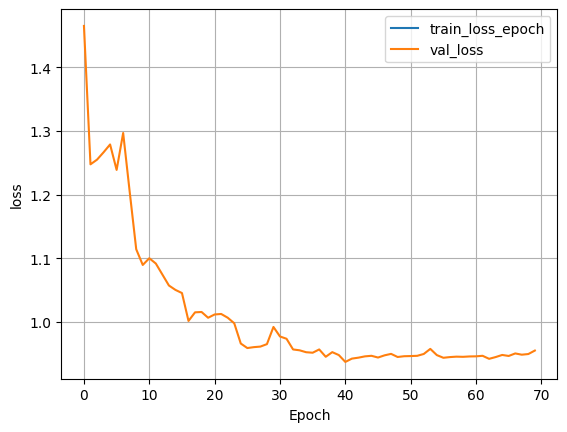

In [24]:
for k in edge_type_weights:
    graph_embedding = HeteroDeepGraphEmbedding6(300, 4, metadata, 32, dropout=0.2, edge_type_count=11, edge_type_weights=edge_type_weights[k])
    graph_embedding = graph_embedding.to(device)
    callbacks = [
    ModelCheckpoint(save_top_k=5, mode='max', monitor='val_acc', save_last=True)
    ]
    loss_func = MulticlassHeteroLoss2(exception_keys=['word'], enc_factor=0.0001)
    optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0045, weight_decay=0.0015)
    lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[8, 16, 24, 32, 40, 55], gamma=0.5, verbose=True)
    lightning_model = HeteroMultiClassLightningModel(graph_embedding, 4,
                                        optimizer=optimizer,
                                        loss_func=loss_func,
                                        learning_rate=0.045,
                                        batch_size=batch_size,
                                        user_lr_scheduler=True,
                                        lr_scheduler=lr_scheduler,
                                        min_lr=0.0005
                                        ).to(device)
    lightning_model.model.to(device)
          
    model_manager = ClassifierModelManager(graph_embedding, lightning_model, log_name='hetero_model_18_AG',device=device, num_train_epoch=70)
    model_manager.fit(datamodule=data_manager)
    model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
    model_manager.torch_model = model_manager.torch_model.to(device)
    save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_18_AG\version_26\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | MulticlassHeteroLoss2     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\dat

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 7.0312e-05.


Validation: |          | 0/? [00:00<?, ?it/s]

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\call.py:58: Detected KeyboardInterrupt, attempting graceful shutdown...


torch.Size([7000, 4])
torch.Size([7000, 4])
torch.Size([7000])
torch.Size([7000])


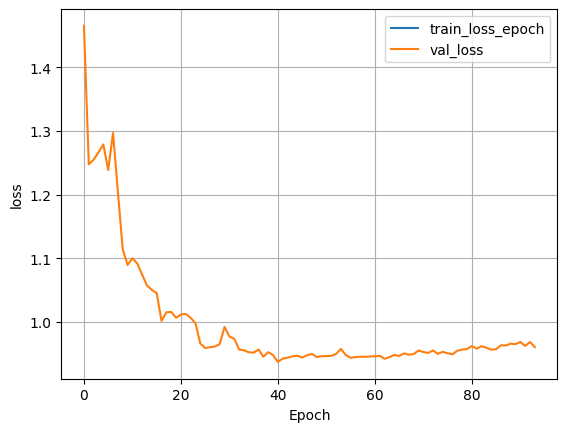

In [26]:
model_manager.trainer.fit_loop.max_epochs=100
# model_manager.trainer.fit_loop.max_steps=-1

model_manager.fit(datamodule=data_manager)
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests2_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.val_dataloader(), f'tests2_{k}',True, True, True, True, True, True, True, multi_class=True)

C:\Users\fardin\AppData\Local\Temp\ipykernel_16560\3676976156.py:58: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.pw1 = torch.nn.Parameter(torch.tensor(self.edge_type_weights, dtype=torch.float32), requires_grad=False)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\utilities\parsing.py:198: Attribute 'model' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['model'])`.


torch.Size([7000, 4])
torch.Size([7000, 4])
torch.Size([7000])
torch.Size([7000])


In [ ]:
torch.cuda.is_available()

False

In [35]:
import pandas as pd
test_df = pd.read_csv(r"data\AG\test.csv", header=None)
g_test_df = test_df.groupby(0)

In [55]:
mega_texts = {}
for g in g_test_df:
    mega_text = ''
    for i in range(g[1].shape[0]):
        mega_text += g[1].iloc[i][1] + ": " + g[1].iloc[i][2]
    print(g[0], g[1].iloc[0][2])
    mega_texts[g[0]] = mega_text

1 Canadian Press - VANCOUVER (CP) - The sister of a man who died after a violent confrontation with police has demanded the city's chief constable resign for defending the officer involved.
2 Michael Phelps won the gold medal in the 400 individual medley and set a world record in a time of 4 minutes 8.26 seconds.
3 Unions representing workers at Turner   Newall say they are 'disappointed' after talks with stricken parent firm Federal Mogul.
4 SPACE.com - TORONTO, Canada -- A second\team of rocketeers competing for the  #36;10 million Ansari X Prize, a contest for\privately funded suborbital space flight, has officially announced the first\launch date for its manned rocket.


In [58]:
from Scripts.DataManager.GraphConstructor.SentimentGraphConstructor import SentimentGraphConstructor


sgc = SentimentGraphConstructor(test_df[1][:10], path.join('', 'sentiment'), config, load_preprocessed_data=False, naming_prepend='graph', start_data_load=0, end_data_load=4, use_sentence_nodes=True , use_general_node=True)

In [72]:
mega_graphs = {}
for k in [1, 2]:
    mega_graphs[k] = sgc.to_graph(mega_texts[k])

KeyboardInterrupt: 

In [62]:
import torch_geometric

In [63]:
mega_X = torch_geometric.data.Batch.from_data_list([mega_graphs[i].to(device) for i in [1, 2, 3, 4]])

In [69]:
lightning_model.eval()

with torch.no_grad():
    y_pred = lightning_model(mega_X.to(device))

In [70]:
if type(y_pred) is tuple:
    y_pred = y_pred[0]
y_pred2 = []
y_pred2 = y_pred.detach().to('cpu')
y_true_num = torch.argmax(y_pred2, dim=1)

In [71]:
y_true_num

tensor([3, 1, 3, 3])

In [66]:
y_pred[0]

(tensor([[ 1246.4675, -2237.6919, -2284.7419,  2301.0710],
         [ 2964.4380,  4919.9702, -3588.7991, -7236.5791],
         [  403.5633, -3150.3320,  -225.1519,  1840.4347],
         [-1008.6052, -2609.5312,  -257.7684,  2605.8118]], device='cuda:0'),
 {'dep': tensor([[6.5649e-05, 6.5649e-05, 6.5649e-05,  ..., 6.5649e-05, 6.5649e-05,
           6.5649e-05],
          [6.5649e-05, 6.5649e-05, 6.5649e-05,  ..., 6.5649e-05, 6.5649e-05,
           6.5649e-05],
          [6.5649e-05, 6.5649e-05, 6.5649e-05,  ..., 6.5649e-05, 6.5649e-05,
           6.5649e-05],
          ...,
          [6.5649e-05, 6.5649e-05, 6.5649e-05,  ..., 6.5649e-05, 6.5649e-05,
           6.5649e-05],
          [6.5649e-05, 6.5649e-05, 6.5649e-05,  ..., 6.5649e-05, 6.5649e-05,
           6.5649e-05],
          [6.5649e-05, 6.5649e-05, 6.5649e-05,  ..., 6.5649e-05, 6.5649e-05,
           6.5649e-05]], device='cuda:0'),
  'tag': tensor([[5.3191e-05, 5.3191e-05, 5.3191e-05,  ..., 5.3191e-05, 5.3191e-05,
           5.3

In [60]:
mega_graphs[1]

HeteroData(
  dep={
    length=45,
    x=[45],
  },
  tag={
    length=50,
    x=[50],
  },
  word={ x=[84994, 300] },
  sentence={ x=[2434, 300] },
  general={ x=[1, 300] },
  sentiment={ x=[2, 300] },
  (dep, dep_word, word)={
    edge_index=[2, 82560],
    edge_attr=[82560],
  },
  (word, word_dep, dep)={
    edge_index=[2, 82560],
    edge_attr=[82560],
  },
  (tag, tag_word, word)={
    edge_index=[2, 84994],
    edge_attr=[84994],
  },
  (word, word_tag, tag)={
    edge_index=[2, 84994],
    edge_attr=[84994],
  },
  (word, seq, word)={
    edge_index=[2, 169986],
    edge_attr=[169986],
  },
  (general, general_sentence, sentence)={
    edge_index=[2, 2434],
    edge_attr=[2434],
  },
  (sentence, sentence_general, general)={
    edge_index=[2, 2434],
    edge_attr=[2434],
  },
  (word, word_sentence, sentence)={
    edge_index=[2, 84994],
    edge_attr=[84994],
  },
  (sentence, sentence_word, word)={
    edge_index=[2, 84994],
    edge_attr=[84994],
  },
  (word, word_sentimen

In [56]:
len(mega_texts[1])

458640

In [17]:

model_manager.lightning_model.loss_func.enc_factor=0.0001
# model_manager.update_learning_rate(0.0003)

optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.0003, weight_decay=0.0012)
model_manager.lightning_model.configure_optimizers()['lr_scheduler']['scheduler'].optimizer = optimizer
# model_manager.lightning_model.configure_optimizers()['lr_scheduler']['scheduler'].milestones = Counter(milestones)
model_manager.lightning_model.optimizer =optimizer

c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_18_AG\version_23\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


bbbb



  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding6 | 205 K 
1 | loss_func | MulticlassHeteroLoss2     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
205 K     Trainable params
23        Non-trainable params
205 K     Total params
0.822     Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=7` in the `DataLoader` to improve performance.
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\dat

Training: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

Adjusting learning rate of group 0 to 3.0000e-04.


Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=70` reached.


torch.Size([7000, 4])
torch.Size([7000, 4])
torch.Size([7000])
torch.Size([7000])


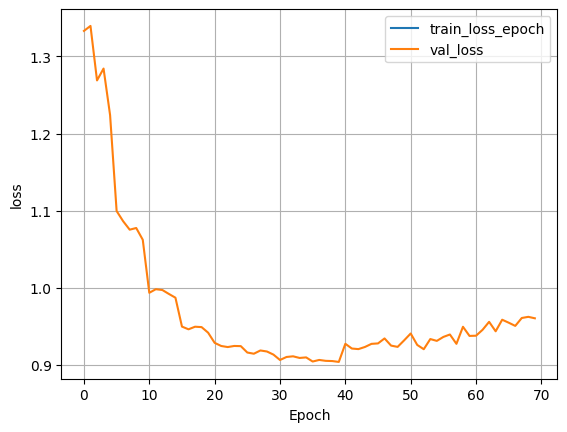

In [19]:
model_manager.fit(datamodule=data_manager)

model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests2_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}2',True, True, True, True, True, True, True, multi_class=True)

In [ ]:
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.test_dataloader(), 'test1_t',True, True, True, True, True, True, True, multi_class=True)

AttributeError: 'AGGraphDataModule' object has no attribute '_AGGraphDataModule__test_dataloader'

In [ ]:
model_manager.trainer.save_checkpoint(r'logs\hetero_model_17_AG\version_12\checkpoints\last_checkpoint_140.ckpt')

In [ ]:
model_manager.update_learning_rate(0.0005625)

In [ ]:
model_manager.fit(datamodule=data_manager, ckpt_path=r'logs\hetero_model_17_AG\version_12\checkpoints\epoch=51-step=24076.ckpt')

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_17_AG\version_12\checkpoints exists and is not empty.
Restoring states from the checkpoint path at logs\hetero_model_17_AG\version_12\checkpoints\epoch=51-step=24076.ckpt
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding5 | 11.6 M
1 | loss_func | MulticlassHeteroLoss2     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
11.6 M    Trainable params
23        Non-trainable params
11.6 M    Total params
46.469    Total estimated model params size (MB)


ValueError: dictionary update sequence element #0 has length 1; 2 is required

In [ ]:
# optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.001, weight_decay=0.0005)
# lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 35], gamma=0.5, verbose=True)
graph_embedding = HeteroDeepGraphEmbedding4(300, 4, X3.metadata(), 256, device, 0.2, 11)
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_11_AG\version_5\checkpoints\epoch=1-step=882.ckpt', 
                                    model=graph_embedding,
                                    num_classes=4)
                                    # ,
                                    # optimizer=optimizer,
                                    # loss_func=loss_func,
                                    # learning_rate=0.001,
                                    # batch_size=batch_size,
                                    # lr_scheduler=lr_scheduler,
                                    # user_lr_scheduler=True,
                                    # min_lr=0.00003)

In [ ]:
from os import path
from sklearn.metrics import classification_report, f1_score, accuracy_score, precision_score, recall_score, confusion_matrix, hinge_loss
import torchmetrics

def save_evaluation(model_mgr, l_model, eval_dataloader, name_prepend: str='',
                 give_confusion_matrix: bool=True, 
                 give_report: bool=True, 
                 give_f1_score: bool=False, 
                 give_accuracy_score: bool=False, 
                 give_precision_score: bool=False, 
                 give_recall_score: bool=False, 
                 give_hinge_loss: bool=False,
                 multi_class: bool=False
                 ):
        
        test_metrics_path = path.join(model_mgr.log_dir, model_mgr.log_name, f'version_{model_mgr.logger.version}', f'{name_prepend}_test_metrics.txt')
        
        y_true = []
        y_pred = []
        for X, y in eval_dataloader:
            l_model.eval()
            with torch.no_grad():
                y_p = l_model(X.to(model_mgr.device))
            if type(y_p) is tuple:
                y_p = y_p[0]
            
            if multi_class:
                y_pred.append(y_p.detach().to(y.device))
                y_true.append(y)
            else:
                y_pred.append((y_p>0).to(torch.int32).detach().to(y.device))
                y_true.append(y.to(torch.int32))
        y_true = torch.concat(y_true)
        y_pred = torch.concat(y_pred)
        print(y_true.shape)
        print(y_pred.shape)
        if multi_class:
            y_true_num = torch.argmax(y_true, dim=1)
            y_pred_num = torch.argmax(y_pred, dim=1)
        else:
            y_true_num = y_true
            y_pred_num = y_pred
            
        print(y_true_num.shape)
        print(y_pred_num.shape)
        with open(test_metrics_path, 'at+') as f:
            if(give_confusion_matrix):
                print(f'confusion_matrix: \n{confusion_matrix(y_true_num, y_pred_num)}', file=f)
            if(give_report):
                print(classification_report(y_true_num, y_pred_num), file=f)
            if(give_f1_score):
                if multi_class:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {f1_score(y_true_num, y_pred_num)}', file=f)
            if(give_accuracy_score):
                print(f'accuracy_score: {accuracy_score(y_true_num, y_pred_num)}', file=f)
            if(give_precision_score):
                if multi_class:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {precision_score(y_true_num, y_pred_num)}', file=f)
            if(give_recall_score):
                if multi_class:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num, average=None)}', file=f)
                else:
                    print(f'f1_score: {recall_score(y_true_num, y_pred_num)}', file=f)
            if(give_hinge_loss):
                print(f'hinge_loss: {hinge_loss(y_true_num, y_pred)}', file=f)
        
        # test_acc = torchmetrics.Accuracy(task="multiclass", num_classes=4)
        # test_f1 = torchmetrics.F1Score(task="multiclass", num_classes=4)
        # test_precision = torchmetrics.Precision(task="multiclass", num_classes=4)
        # test_recall = torchmetrics.Recall(task="multiclass", num_classes=4)
        # test_confusion_m = torchmetrics.ConfusionMatrix(task="multiclass", num_classes=4)
        
        # print(f'test_acc: {test_acc(y_true_num, y_pred_num)}')
        # print(f'test_f1: {test_f1(y_true_num, y_pred_num)}')
        # print(f'test_precision: {test_precision(y_true_num, y_pred_num)}')
        # print(f'test_recall: {test_recall(y_true_num, y_pred_num)}')
        # print(f'test_confusion_m: \n{test_confusion_m(y_true_num, y_pred_num)}')

In [ ]:
lightning_model.optimizer

Adam (
Parameter Group 0
    amsgrad: False
    betas: (0.9, 0.999)
    capturable: False
    differentiable: False
    eps: 1e-08
    foreach: None
    fused: None
    lr: 0.01
    maximize: False
    weight_decay: 0
)

In [ ]:
save_evaluation(model_manager, lightning_model, data_manager.test_dataloader(), 'chpt_n',True, True, True, True, True, True, True, multi_class=True)

torch.Size([6985, 4])
torch.Size([6985, 4])
torch.Size([6985])
torch.Size([6985])


In [ ]:
optimizer = torch.optim.Adam(graph_embedding.parameters(), lr=0.001, weight_decay=0.0005)
lr_scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[5, 15, 35], gamma=0.5, verbose=True)
lightning_model = HeteroMultiClassLightningModel.load_from_checkpoint(r'logs\hetero_model_16_AG\version_12\checkpoints\epoch=137-step=60858.ckpt', 
                                    model=graph_embedding,
                                    num_classes=4)
        
save_evaluation(model_manager, lightning_model, data_manager.test_dataloader(), 'chpt_1',True, True, True, True, True, True, True, multi_class=True)

Adjusting learning rate of group 0 to 1.0000e-03.


RuntimeError: Only Tensors created explicitly by the user (graph leaves) support the deepcopy protocol at the moment

In [ ]:
model_manager.trainer.fit_loop.max_epochs=100
model_manager.trainer.fit_loop.max_steps=-1

model_manager.fit(datamodule=data_manager)

bbbb


c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\callbacks\model_checkpoint.py:630: Checkpoint directory logs/hetero_model_16_AG\version_12\checkpoints exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name      | Type                      | Params
--------------------------------------------------------
0 | model     | HeteroDeepGraphEmbedding5 | 4.0 M 
1 | loss_func | MulticlassHeteroLoss1     | 0     
2 | train_acc | MulticlassAccuracy        | 0     
3 | val_acc   | MulticlassAccuracy        | 0     
4 | test_acc  | MulticlassAccuracy        | 0     
--------------------------------------------------------
4.0 M     Trainable params
11        Non-trainable params
4.0 M     Total params
15.957    Total estimated model params size (MB)
c:\Users\fardin\AppData\Local\Programs\Python\Python310\lib\site-packages\lightning\pytorch\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers whi

In [ ]:

model_manager.trainer.model.eval()
model_manager.trainer.model(X3)

(tensor([[ 0.0119, -5.3836, -0.8138,  5.6585],
         [-0.5171, -1.4353, -1.7620,  3.3852],
         [-0.5625, -3.4890,  0.5424,  3.2266],
         ...,
         [ 0.6585,  5.6110, -4.2732, -2.3721],
         [ 7.6873, -8.2410, -0.7907,  0.7995],
         [-1.3680, -2.5770,  2.6620,  0.9521]], grad_fn=<AddmmBackward0>),
 {'dep': tensor([[0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          ...,
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001],
          [0.0001, 0.0001, 0.0002,  ..., 0.0001, 0.0001, 0.0001]],
         grad_fn=<LeakyReluBackward0>),
  'tag': tensor([[0.0002, 0.0001, 0.0001,  ..., 0.0001, 0.0002, 0.0001],
          [0.0002, 0.0001, 0.0001,  ..., 0.0001, 0.0002, 0.0001],
          [0.0002, 0.0001, 0.0001,  ..., 0.0001, 0.0002, 0.0001],
          ..

In [ ]:
# t_dataloader = data_manager.train_dataloader()

for X1, y1 in val_dataloader:
    model_manager.trainer.model.eval()
    with torch.no_grad():
        y1_pred = model_manager.trainer.model(X1.to(device))
    acc = model_manager.lightning_model.train_acc(torch.argmax(y1_pred[0], dim=1), torch.argmax(y1.to(device), dim=1))
    print(acc)

RuntimeError: Expected all tensors to be on the same device, but found at least two devices, cpu and cuda:0! (when checking argument for argument index in method wrapper_CUDA__index_select)

In [ ]:
# X1, y1 = next(iter(t_dataloader))
model_manager.lightning_model.train_acc

MulticlassAccuracy()

torch.Size([6985, 4])
torch.Size([6985, 4])
torch.Size([6985])
torch.Size([6985])
test_acc: 0.881030797958374
test_f1: 0.881030797958374
test_precision: 0.881030797958374
test_recall: 0.881030797958374
test_confusion_m: 
tensor([[1530,   35,   45,   74],
        [  37, 1632,    8,    9],
        [ 136,   42, 1454,  114],
        [  54,   39,  238, 1538]])


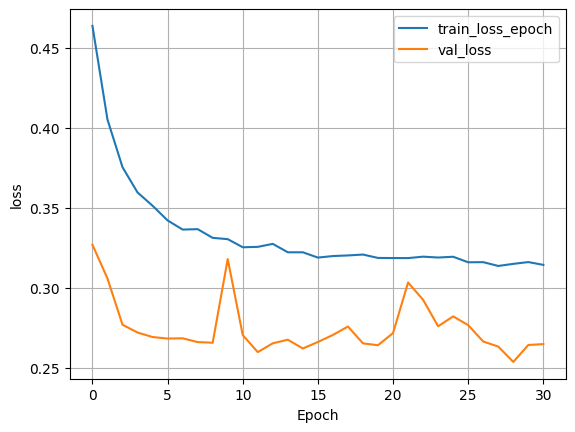

In [ ]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.test_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

test_acc: 0.6729172468185425
test_f1: 0.6729172468185425
test_precision: 0.6729172468185425
test_recall: 0.6729172468185425
test_confusion_m: 
tensor([[1699,  441,  676,  424],
        [  17, 1312,   16,   26],
        [  18,    8, 1111,  625],
        [  10,    8,   16,  579]])


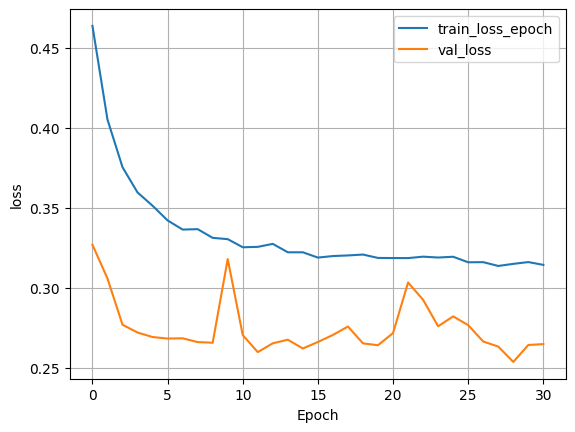

In [ ]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.val_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)

test_acc: 0.6320773363113403
test_f1: 0.6320773363113403
test_precision: 0.6320773363113403
test_recall: 0.6320773363113403
test_confusion_m: 
tensor([[27739,  8801, 11597,  9042],
        [  179, 19189,   332,   429],
        [  223,   121, 15893, 10335],
        [   79,    75,   324,  8538]])


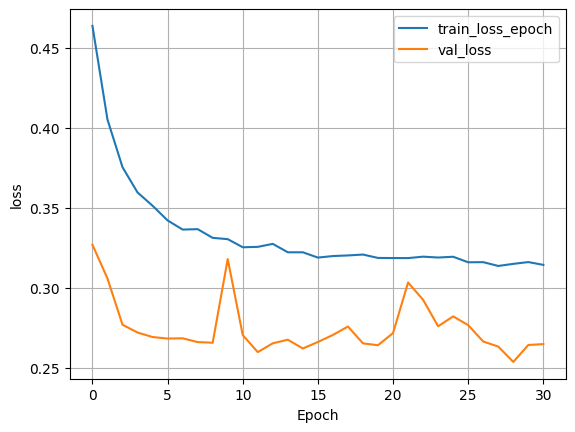

In [ ]:
model_manager.save_plot_csv_logger(loss_names=['train_loss_epoch', 'val_loss'], eval_names=['train_acc_epoch', 'val_acc'], name_prepend=f'tests_{k}')
model_manager.torch_model = model_manager.torch_model.to(device)
save_evaluation(model_manager, data_manager.train_dataloader(), f'{k}',True, True, True, True, True, True, True, multi_class=True)